In [ ]:
!pip install geopandas
!pip install pyclustertend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from math import ceil

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gp
import scipy.stats as st

from pyclustertend import hopkins

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score, make_scorer, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
warnings.simplefilter(action='ignore')

In [ ]:
df_properati = pd.read_csv("properati_argentina_2021.csv")

# [1] ★ Análisis Exploratorio y Preprocesamiento de Datos

In [ ]:
df_properati.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


In [ ]:
df_properati.shape

(460154, 20)

## Filtrado **inicial** - Selección de Datos

In [ ]:
df_properati.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


In [ ]:
df_properati["property_type"].unique()

array(['Casa', 'PH', 'Departamento', 'Lote', 'Depósito', 'Otro',
       'Local comercial', 'Oficina', 'Casa de campo', 'Cochera'],
      dtype=object)

In [ ]:
home_type_query = "(property_type == 'Casa' | property_type == 'PH' | property_type == 'Departamento')"
place_query = "place_l2 == 'Capital Federal'"
operation_query = "operation == 'Venta'"
currency_query = "property_currency == 'USD'"


df_filtered = df_properati.query(f"{home_type_query} & {place_query} & {operation_query} & {currency_query}")
df_filtered.reset_index(drop=True, inplace=True)

In [ ]:
df_filtered.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,USD,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA
1,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,USD,VENTA TRES AMBIENTES LA BOCA PISO ALTO
2,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,USD,Departamento - 4 Ambientes - Catalinas Sur
3,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,NaN,NaN,NaN,Venta,Departamento,4.0,2.0,NaN,104.0,146000.0,USD,Venta departamento 4 ambientes Once
4,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,NaN,NaN,NaN,Venta,PH,4.0,2.0,NaN,73.0,250000.0,USD,PH - Boedo


In [ ]:
df_filtered.shape

(94249, 20)

Separacion en train y test

In [ ]:
#Separamos conjunto de Train y de Test (80/20)
train, test = train_test_split(df_filtered, test_size=0.20, random_state=0)

## a) ◆ Exploración Inicial

### ● Tipo de variable



In [ ]:
train.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
place_l3                     object
place_l4                     object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

Como preanálisis, hay algunas variables (como start_date o end_date) que podrían cambiarse el tipo de dato a DateTime. Otras, como property_type, son categóricas, con lo cual podrían transformarse con One Hot Encoding. Otras, como id, operation y place_l6 son variables que no son relevantes para el análisis.

### ● Variables cuantitativas

In [ ]:
df_quantitatives_desc = train.describe()

df_quantitatives_desc = df_quantitatives_desc.append(train.mode(numeric_only=True))
df_quantitatives_desc.rename(index={0:"mode", "25%":"Q1", "50%":"median", "75%":"Q3"}, inplace=True)

df_quantitatives_desc

,latitud,longitud,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
count,72393.000000,72393.000000,0.0,74568.000000,66659.000000,71554.000000,72694.000000,7.539900e+04
mean,-34.591533,-58.449751,NaN,2.824120,2.015962,112.591274,88.870856,2.272012e+05
std,0.187601,0.292335,NaN,1.420507,1.142591,1092.831135,1063.132930,3.247706e+05
min,-53.788624,-71.471192,NaN,1.000000,-1.000000,10.000000,1.000000,5.000000e+03
Q1,-34.615975,-58.466432,NaN,2.000000,1.000000,45.000000,40.000000,9.500000e+04
median,-34.595789,-58.438956,NaN,3.000000,2.000000,65.000000,58.000000,1.440000e+05
Q3,-34.577400,-58.408862,NaN,4.000000,3.000000,105.000000,88.000000,2.360000e+05
max,-24.219827,-54.133330,NaN,36.000000,70.000000,137000.000000,217000.000000,2.140000e+07
mode,-34.541250,-58.472966,NaN,3.000000,1.000000,50.000000,40.000000,1.100000e+05


Como podemos ver, property_bedrooms tiene un valor minimo de -1. Observaremos esta fila mas en detalle:

In [ ]:
train[train['property_bedrooms'] <= 0]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
82905,3WI+zCCMeb9TR5kOBm7rhg==,2021-01-07,2021-03-18,2021-01-07,-34.577595,-58.495185,Capital Federal,Villa Urquiza,NaN,NaN,NaN,Venta,Departamento,2.0,-1.0,61.0,43.0,125000.0,USD,Jardines de Roosevelt - Hermoso 3 ambientes co...


Viendo que solo es una fila, la eliminaremos:

In [ ]:
train = train[train['property_bedrooms'] != -1]
train.shape

(75398, 20)

In [ ]:
test = test[test['property_bedrooms'] != -1]
test.shape

(18850, 20)

### ● Variables cualitativas

In [ ]:
df_qualitatives_desc = train.describe(exclude=np.number)
df_qualitatives_desc.drop("top", inplace=True)

df_qualitatives_desc

,id,start_date,end_date,created_on,place_l2,place_l3,place_l4,place_l5,operation,property_type,property_currency,property_title
count,75398,75398,75398,75398,75398,75074,2982,0,75398,75398,75398,75398
unique,75398,365,604,365,1,57,4,0,1,3,1,46431
freq,1,3736,10209,3736,75398,11525,1281,NaN,75398,64686,75398,1198


### ● Variables irrelevantes

Vamos a revisar algunas variables:

In [ ]:
train[train.start_date != train.created_on].empty

True

En base a esto, vemos que la variable created_on aporta la misma informacion (para este dataset) que start_date. Con lo cual, es irrelevante.

En los casos de las variables place_l#, vemos que **place_l2** hace referencia a la provincia/distrito. Como todos estos datos son de Capital Federal, la variable es irrelevante.

In [ ]:
train[train.place_l2 != "Capital Federal"].empty

True

**place_l3** hace referencia (con estos datos) a los barrios porteños. 

**place_l4**, para este dataset, hace las veces de clasificador de "tipos de Palermos".

In [ ]:
train[~train.place_l4.isna() & (train.place_l4.str.contains("Palermo") == False)].empty

True

**place_l5** y **place_l6** no aportan información. Son irrelevantes

In [ ]:
train[~train.place_l5.isna() | ~train.place_l6.isna() ].empty

True

La variable **operation** se encuentra prefijada en un valor específico (operaciones de venta). Es irrelevante.

Ocurre lo mismo en **property_currency** (Solo USD) 

La variable **id** es un identificador único para cada propiedad, irrelevante para el análisis.

A continuación borramos las columnas irrelevantes:

Las variables start_date y end_date las eliminaremos ya que no aportan valor a nuestro analisis. 

In [ ]:
columns_delete = ["id","created_on","property_currency","operation","place_l2","place_l5","place_l6", "start_date", "end_date"]
train.drop(columns_delete, axis='columns', inplace=True)
test.drop(columns_delete, axis='columns', inplace=True)
df_filtered.drop(columns_delete, axis='columns', inplace=True)
train.head()

,latitud,longitud,place_l3,place_l4,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
57333,-34.601807,-58.469965,Paternal,NaN,Departamento,2.0,1.0,53.0,49.0,80000.0,Venta Depto 2 Amb c/balcon. Av San Martin.Pate...
52155,-34.580088,-58.424965,Palermo,NaN,Departamento,2.0,1.0,35.0,35.0,79900.0,1 - Fray Justo Sta. Maria de Oro 2400
28134,-34.551481,-58.452358,Belgrano,NaN,Departamento,1.0,1.0,25.0,20.0,69000.0,Venta depto mono ambiente Belgrano. Ugarte1500
46503,-34.632290,-58.464844,Flores,NaN,Departamento,5.0,3.0,75.0,75.0,150000.0,VENTA 5 AMBIENTES CON BALCÓN EN FLORES!!
83299,-34.549279,-58.463074,Nuñez,NaN,Departamento,2.0,1.0,46.0,34.0,85000.0,Departamento 2 ambientes con patio en venta - ...


In [ ]:
train.shape

(75398, 11)

Cambiamos nombre de variables

In [ ]:
new_names = {
    "place_l3":"neighborhood",
    "place_l4":"palermo_type",
    "property_type":"type",
    "property_rooms":"rooms",
    "property_bedrooms":"bedrooms",
    "property_surface_total":"surface_total",
    "property_surface_covered":"surface_covered",
    "property_price":"price",
    "property_title":"title"
}

df_filtered.rename(columns=new_names, inplace=True)
train.rename(columns=new_names, inplace=True)
test.rename(columns=new_names, inplace=True)

train.head()

,latitud,longitud,neighborhood,palermo_type,type,rooms,bedrooms,surface_total,surface_covered,price,title
57333,-34.601807,-58.469965,Paternal,NaN,Departamento,2.0,1.0,53.0,49.0,80000.0,Venta Depto 2 Amb c/balcon. Av San Martin.Pate...
52155,-34.580088,-58.424965,Palermo,NaN,Departamento,2.0,1.0,35.0,35.0,79900.0,1 - Fray Justo Sta. Maria de Oro 2400
28134,-34.551481,-58.452358,Belgrano,NaN,Departamento,1.0,1.0,25.0,20.0,69000.0,Venta depto mono ambiente Belgrano. Ugarte1500
46503,-34.632290,-58.464844,Flores,NaN,Departamento,5.0,3.0,75.0,75.0,150000.0,VENTA 5 AMBIENTES CON BALCÓN EN FLORES!!
83299,-34.549279,-58.463074,Nuñez,NaN,Departamento,2.0,1.0,46.0,34.0,85000.0,Departamento 2 ambientes con patio en venta - ...


### ● Análisis gráfico de las distribuciones de las variables

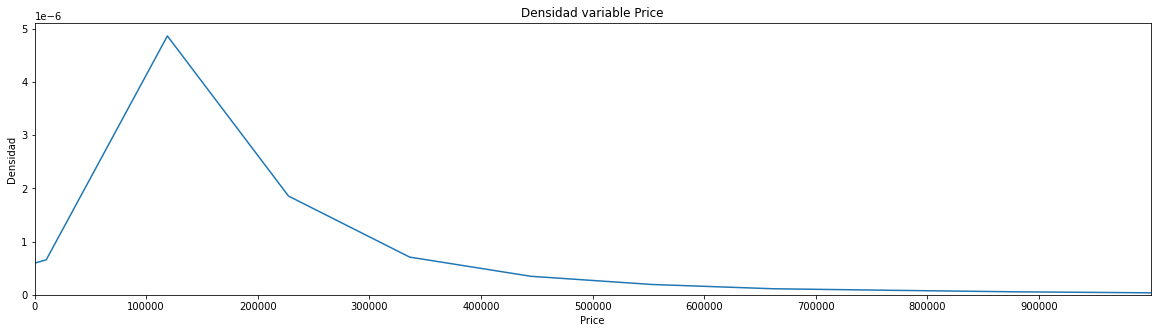

In [ ]:
plt.figure(figsize = (20,5))
sns_hist=sns.kdeplot(data=train['price']).set(title="Densidad variable Price",xlabel="Price",ylabel="Densidad",xlim=(0,1000000),xticks = (range(0,1000000,100000)))

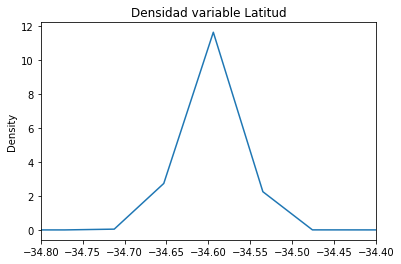

In [ ]:
train['latitud'].plot.kde(title="Densidad variable Latitud",xlabel="Latitud",ylabel="Densidad",xlim=(-34.8,-34.4))

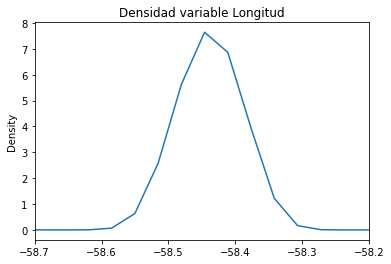

In [ ]:
train['longitud'].plot.kde(title="Densidad variable Longitud",xlabel="Longitud",ylabel="Densidad",xlim=(-58.7,-58.2))

In [ ]:
train.head()

,latitud,longitud,neighborhood,palermo_type,type,rooms,bedrooms,surface_total,surface_covered,price,title
57333,-34.601807,-58.469965,Paternal,NaN,Departamento,2.0,1.0,53.0,49.0,80000.0,Venta Depto 2 Amb c/balcon. Av San Martin.Pate...
52155,-34.580088,-58.424965,Palermo,NaN,Departamento,2.0,1.0,35.0,35.0,79900.0,1 - Fray Justo Sta. Maria de Oro 2400
28134,-34.551481,-58.452358,Belgrano,NaN,Departamento,1.0,1.0,25.0,20.0,69000.0,Venta depto mono ambiente Belgrano. Ugarte1500
46503,-34.632290,-58.464844,Flores,NaN,Departamento,5.0,3.0,75.0,75.0,150000.0,VENTA 5 AMBIENTES CON BALCÓN EN FLORES!!
83299,-34.549279,-58.463074,Nuñez,NaN,Departamento,2.0,1.0,46.0,34.0,85000.0,Departamento 2 ambientes con patio en venta - ...


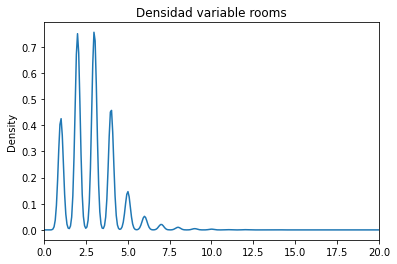

In [ ]:
train['rooms'].plot.kde(title="Densidad variable rooms",xlabel="rooms",ylabel="Densidad", xlim=(0,20))

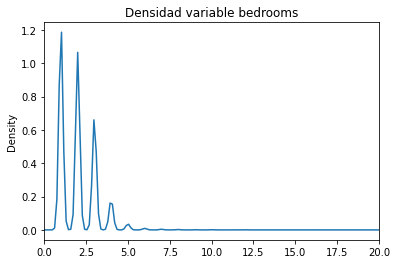

In [ ]:
train['bedrooms'].plot.kde(title="Densidad variable bedrooms",xlabel="bedrooms",ylabel="Densidad", xlim=(0,20))

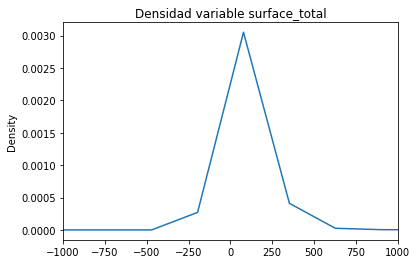

In [ ]:
train['surface_total'].plot.kde(title="Densidad variable surface_total",xlabel="surface_total",ylabel="Densidad", xlim=(-1000,1000))

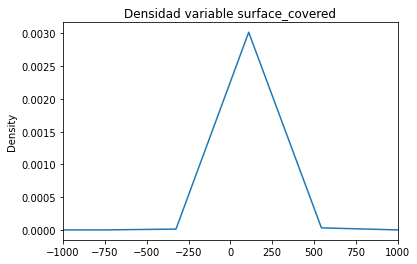

In [ ]:
train['surface_covered'].plot.kde(title="Densidad variable surface_covered",xlabel="surface_covered",ylabel="Densidad", xlim=(-1000,1000))

### ● Analizar las correlaciones existentes entre las variables

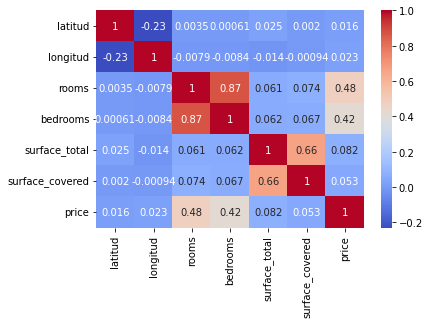

In [ ]:
sns.heatmap(train.corr(),annot=True, cmap = 'coolwarm')

Hay varias relaciones notables:
*   Cantidad de habitaciones vs cantidad de dormitorios (0.87)
*   Superficie cubierta vs superficie total (0.66)
*   Cantidad de habitaciones vs precio de propiedad (0.48)
*   Cantidad de dormitorios vs precio de propiedad (0.42)
*   Latitud vs Longitud (-0.23)


## b) ◆ Datos faltantes

### ● Análisis a nivel columna

<BarContainer object of 11 artists>

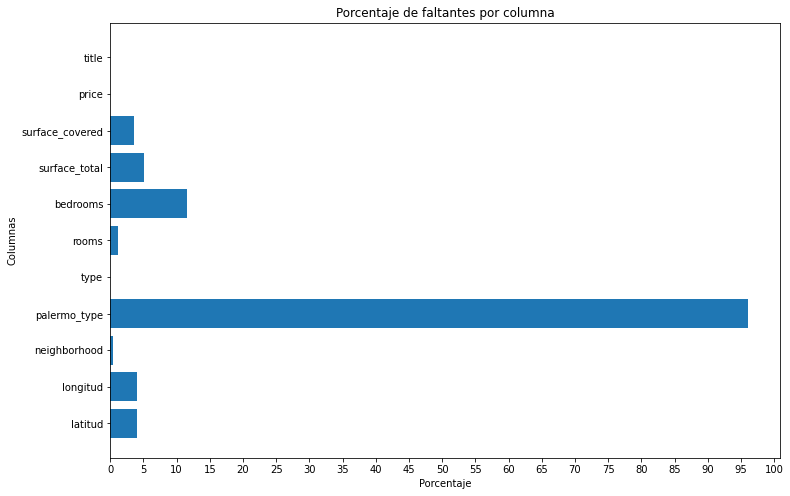

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("Porcentaje de faltantes por columna")
plt.xlabel("Porcentaje")
plt.xticks(range(0,101,5))
plt.ylabel("Columnas")
plt.barh(train.columns.to_list(), train.isna().sum()/train.shape[0]*100 )

Vemos que la variable palermo_type tiene mas de 95% de datos faltantes. Tampoco nos sirve para reemplazar los datos cuando `neighbourhood = Palermo`, ya que no hay datos suficientes paa sobreescribir dicha columna con dicha condición.


In [ ]:
train[train.neighborhood == 'Palermo'].palermo_type.isna().value_counts()

True     8543
False    2982
Name: palermo_type, dtype: int64

In [ ]:
df_filtered.drop('palermo_type', axis='columns', inplace=True)
train.drop('palermo_type', axis='columns', inplace=True)
test.drop('palermo_type', axis='columns', inplace=True)

In [ ]:
train.shape

(75398, 10)

Siendo tan pocos los campos nulls de latitud y longitud, los borraremos. Pero la variable permanece ya que puede aportar para el analisis de valores atípicos.Lo mismo con neighbourhood.

In [ ]:
df_filtered = df_filtered[~(df_filtered.latitud.isnull() & df_filtered.longitud.isnull() & df_filtered.neighborhood.isnull())]
train = train[~(train.latitud.isnull() & train.longitud.isnull())]
test = test[~(test.latitud.isnull() & test.longitud.isnull())]

df_filtered = df_filtered[~(df_filtered.neighborhood.isnull())]
train = train[~(train.neighborhood.isnull())]
test = test[~(test.neighborhood.isnull())]

In [ ]:
train.shape

(72196, 10)

In [ ]:
test.shape

(18075, 10)

### ● Análisis a nivel fila

**Realizar un análisis de datos faltantes a nivel de fila.** Calcular el porcentaje de datos faltantes de cada registro. Realizar un gráfico que permita conocer la
proporción de faltantes por fila en el dataset.

<BarContainer object of 4 artists>

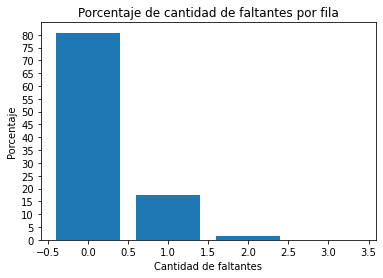

In [ ]:
row_null_series = train.isnull().sum(axis=1).value_counts()/train.shape[0]*100

plt.title("Porcentaje de cantidad de faltantes por fila")
plt.xlabel("Cantidad de faltantes")
plt.ylabel("Porcentaje")
plt.yticks(np.arange(0, 100, 5))

plt.bar(row_null_series.index, row_null_series.values)

Analisis de datos con caracteres raros (Vemos que no hay):

In [ ]:
has_dash = train.astype('str').eq('-').any(0)
has_dot = train.astype('str').eq('.').any(0)
has_whitespace = train.astype('str').eq(' ').any(0)
has_null = train.astype('str').eq('null').any(0)
has_dot & has_dash & has_whitespace & has_null

latitud            False
longitud           False
neighborhood       False
type               False
rooms              False
bedrooms           False
surface_total      False
surface_covered    False
price              False
title              False
dtype: bool

Analisis de datos duplicados. Hemos encontrado datos de este tipo, con lo cual serán borrados:

In [ ]:
train[train.duplicated(keep=False)].head()

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title
84090,-34.589588,-58.431352,Palermo,Casa,5.0,3.0,290.0,230.0,815000.0,Impecable Casa en Calle Serrano 5 amb . 290 me...
51155,-34.587275,-58.513193,Villa Devoto,PH,5.0,3.0,173.0,153.0,320000.0,PH - Villa Devoto
85648,-34.636947,-58.417606,Boedo,Departamento,2.0,1.0,34.0,34.0,65000.0,"Departamento en venta 2amb, ideal inversor!"
30545,-34.604188,-58.399590,Once,Departamento,3.0,2.0,41.0,41.0,55000.0,Departamento 2 ambientes bao cocina Y PATIO CU...
54872,-34.579268,-58.440205,Palermo,Departamento,2.0,1.0,75.0,34.0,182000.0,Departamento de 2 ambientes en construcción en...


In [ ]:
size_before = len(train)
train = train.drop_duplicates()
size_after = len(train)
print(f'Se eliminaron: {size_before-size_after} filas duplicadas')

Se eliminaron: 7479 filas duplicadas


In [ ]:
size_before = len(test)
test = test.drop_duplicates()
size_after = len(test)
print(f'Se eliminaron: {size_before-size_after} filas duplicadas')

Se eliminaron: 701 filas duplicadas


### ● Análisis de reparación de valores faltantes
La columna neighborhood, tiene un porcentaje muy bajo de datos nulos. Las propiedades en venta que contienen estos datos faltantes, seran analizadas posteriomente ya que tenemos la hipotesis de que pueden resultar ser datos atipicos basandonos en su latitud y longitud.

En el caso de las propiedades con latitud y longitud faltantes, las eliminamos.

Notamos tambien, que hay propiedades con surface_covered y surface_total faltantes. Debido a que su correlacion es alta (como vimos previamente) podemos imputarlas entre si usando el algoritmo MICE

Para el caso de rooms y bedrooms, podemos seguir la misma logica. 

In [ ]:
columns=['surface_total','surface_covered']
train_columns_to_fill = train[columns].copy()

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=20, verbose=0, random_state=0) #imputation_order='roman'
train_new_columns = imp.fit_transform(train_columns_to_fill)

train[['surface_total','surface_covered']] = train_new_columns

In [ ]:
test_columns_to_fill = test[columns].copy()
test_new_columns = imp.transform(test_columns_to_fill)

test[['surface_total','surface_covered']] = test_new_columns

Comprobamos que no quedaron datos nulos:

In [ ]:
train.surface_total.isnull().sum()

0

In [ ]:
train.surface_covered.isnull().sum()

0

In [ ]:
columns=['bedrooms','rooms']
train_columns_to_fill = train[columns].copy()

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=20, verbose=0, random_state=0) #imputation_order='roman'
train_new_columns = imp.fit_transform(train_columns_to_fill)

train[['bedrooms','rooms']] = train_new_columns.astype("int")

In [ ]:
test_columns_to_fill = test[columns].copy()

test_new_columns = imp.transform(test_columns_to_fill)

test[['bedrooms','rooms']] = test_new_columns.astype(int)

Chequeamos que no queden valores nulos:

In [ ]:
train.bedrooms.isnull().sum()

0

In [ ]:
train.rooms.isnull().sum()

0

In [ ]:
train.reset_index(drop=True, inplace=True) #Reseteamos index
test.reset_index(drop=True, inplace=True) #Reseteamos index

## c) ◆ Valores atípicos

### ● Análisis univariado

Utilizamos zscore para realizar un análisis de valores atípicos de manera univariada.

In [ ]:
train['z_price']=st.zscore(train.price)


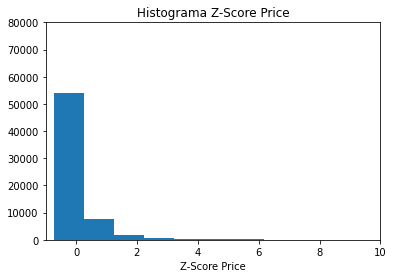

In [ ]:
plt.hist(train.z_price,bins=75)
plt.title('Histograma Z-Score Price')
plt.xlabel('Z-Score Price')
plt.xlim(-1,10)
plt.ylim(0,80000)
plt.show()

In [ ]:
train[(train.z_price < -3) | (train.z_price > 3)].shape


(1028, 11)

In [ ]:
train[train.z_price > 3].shape


(1028, 11)

Como podemos ver, hay mas de 1200 valores atipicos. Ahora pasaremos a analizar mas detenidamente:

In [ ]:
train[train.z_price > 3].head()

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title,z_price
23,-34.614981,-58.362643,Puerto Madero,Departamento,6,5,500.0,470.0,2950000.0,DEPTO 6 AMB VENTA EN PUERTO MADERO ALEPH FAENA,9.459677
40,-34.593098,-58.390295,Recoleta,Departamento,7,5,624.0,624.0,1111111.0,"VENTA/ALQ piso 7 amb de estilo francés, 2 coch...",3.103151
75,-34.568032,-58.441285,Belgrano,Casa,6,5,550.0,550.0,1580000.0,FANTASTICA CASA TOTALMENTE RECICLADA CON PILET...,4.723969
92,-34.611244,-58.360546,Puerto Madero,Departamento,4,2,220.0,220.0,1680000.0,VENTA Exc. semipiso MUY ALTO a nuevo 220 m2 T...,5.069641
168,-34.613289,-58.362148,Puerto Madero,Departamento,3,2,466.0,319.0,3000000.0,Departamento - Puerto Madero,9.632513


Analizamos los extremos:

In [ ]:
train[train.z_price == train.z_price.max()]

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title,z_price
10927,-34.616044,-58.458621,Caballito,Departamento,3,1,68.0,64.0,21400000.0,Departamento venta,73.236175


In [ ]:
train[train.z_price == train.z_price.min()]

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title,z_price
4909,-34.610046,-58.361382,Puerto Madero,Departamento,4,3,194.0,194.0,5000.0,Departamento - Puerto Madero,-0.720366
63009,-34.587265,-58.389767,Recoleta,Departamento,12,8,385.0,385.0,5000.0,Departamento venta,-0.720366


Notamos que el maximo pareceria ser un valor erroneamente cargado ya que nos parece que el precio es excesivo para el tamano y la zona de la propiedad. En el caso de los minimos, nos parece que es posible que existan propiedades con este precio. Segun este analisis, eliminaremos el maximo.

In [ ]:
train = train[train.z_price != train.z_price.max()]

Vemos a simple vista que las demas propiedades marcadas como outliers, tienen ese valor por estar en zonas privilegiadas de CABA. Con lo cual, no son outliers, sino que la zona es cara en cuanto a valor por m2.

Analizamos el caso de latitud:

In [ ]:
train['z_latitud']=st.zscore(train.latitud)

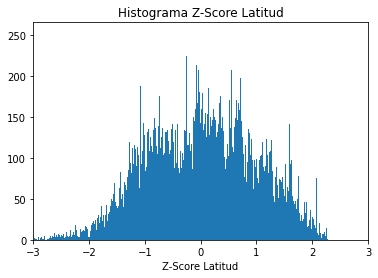

In [ ]:
plt.hist(train.z_latitud,bins=1000)
plt.title('Histograma Z-Score Latitud')
plt.xlabel('Z-Score Latitud')
plt.xlim(-3,3)
plt.show()

In [ ]:
train[(train.z_latitud < -3) | (train.z_latitud > 3)].shape


(268, 12)

In [ ]:
train[(train.z_latitud < -3) | (train.z_latitud > 3)].head()

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title,z_price,z_latitud
261,-34.679272,-58.475503,Villa Lugano,Departamento,2,1,55.0,49.0,138000.0,Departamento Premium en venta 2 amb. V. Lugano,-0.260622,-3.117182
345,-34.679576,-58.474624,Villa Lugano,Departamento,2,1,70.0,31.0,119000.0,"VENTA DEPTO. 2 AMB. CON BALCON TERRAZA, V. LUGANO",-0.326300,-3.128658
387,-34.686350,-58.477110,Villa Lugano,Departamento,3,2,50.0,50.0,115000.0,VENTA DEPARTAMENTO 3 AMBIENTES LUGANO,-0.340127,-3.384207
596,-34.683041,-58.463997,Villa Lugano,Departamento,3,2,49.0,49.0,45000.0,Hermoso Departamento 3 ambientes con vista,-0.582097,-3.259373
1888,-34.676647,-58.475869,Villa Lugano,Departamento,2,1,52.0,32.0,77000.0,VENTA DEPARTAMENTO DOS AMBIENTES VILLA LUGANO,-0.471482,-3.018158


Basados en el dato que nos proporciona el título de la propiedad, podemos suponer que estos datos no pertenecen a CABA. Ejemplos:

Venta casa 3 ambientes s/ lote 1016 m2 SAN PEDRO

Dúplex barrio Los Prados - La Calera [ESTO ES CORDOBA]

Venta Casa en Manzanares Barrio Abierto [MANZANARES, PROV DE BS AS]

Es por ello, que los eliminamos (tambien del set de test):

In [ ]:
train = train[~((train.z_latitud < -3) | (train.z_latitud > 3))]
train.shape

(64448, 12)

In [ ]:
test['z_latitud']=st.zscore(test.latitud)
test = test[~((test.z_latitud < -3) | (test.z_latitud > 3))]
test.shape

(17286, 11)

Analizamos el caso de la longitud:

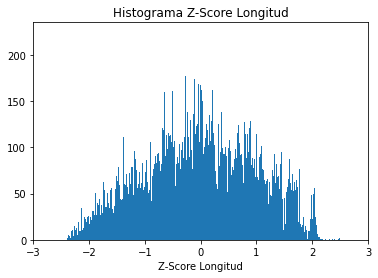

In [ ]:
train['z_longitud']=st.zscore(train.longitud)

plt.hist(train.z_longitud,bins=1000)
plt.title('Histograma Z-Score Longitud')
plt.xlabel('Z-Score Longitud')
plt.xlim(-3,3)
plt.show()

In [ ]:
train[(train.z_longitud < -3) | (train.z_longitud > 3)].shape

(0, 13)

In [ ]:
train[(train.z_longitud < -3) | (train.z_longitud > 3)].head()

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title,z_price,z_latitud,z_longitud


Estas propiedades las hemos visto en Google Maps (usando latitud y longitud). Ambas son de un edificio en Laboulaye, Cordoba. No se condice con lo que enuncia el titulo de propiedad (que estas propiedades están en Saenz Peña, Tres de Febrero). Por estas inconsistencias, las sacamos:

In [ ]:
train = train[~((train.z_longitud < -3) | (train.z_longitud > 3))]
train.shape

(64448, 13)

In [ ]:
test['z_longitud']=st.zscore(test.longitud)
test = test[~((test.z_longitud < -3) | (test.z_longitud > 3))]
test.shape

(17286, 12)

Analizamos surface_total y surface_covered: 

In [ ]:
train['z_surface_total']=st.zscore(train.surface_total)

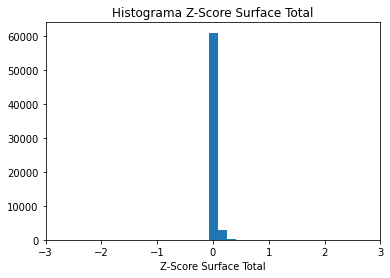

In [ ]:
plt.hist(train.z_surface_total,bins=1000)
plt.title('Histograma Z-Score Surface Total')
plt.xlabel('Z-Score Surface Total')
plt.xlim(-3,3)
plt.show()

In [ ]:
train[(train.z_surface_total < -3) | (train.z_surface_total > 3)].shape

(34, 14)

In [ ]:
train[(train.z_surface_total < -3) | (train.z_surface_total > 3)].head()

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title,z_price,z_latitud,z_longitud,z_surface_total
1011,-34.571747,-58.422612,Palermo,Departamento,5,4,42110.0,307.0,3044250.0,Reventa - Departamento - Palermo Nuevo - Liber...,9.785473,0.939027,0.426590,30.197641
1520,-34.571747,-58.422612,Palermo,Departamento,5,4,42110.0,307.0,2890500.0,Reventa - Departamento - Palermo Nuevo - Liber...,9.254002,0.939027,0.426590,30.197641
1662,-34.628397,-58.437706,Caballito,Departamento,3,2,8136.0,6472.0,203550.0,3 Ambientes Venta de Pozo Caballito Full Ameni...,-0.034034,-1.198015,0.031169,5.769206
3825,-34.588175,-58.396261,Recoleta,Departamento,1,0,36000.0,30.0,90000.0,Departamento Monoambiente alquiler temporario ...,-0.426545,0.319286,1.116884,25.804348
6887,-34.587320,-58.401556,Barrio Norte,Departamento,2,1,56740.0,52540.0,175000.0,EXCELENTE DEPARTAMENTO DE 2 AMBIENTES DE CATEG...,-0.132723,0.351546,0.978181,40.717097


In [ ]:
train[(train.z_surface_total < -3) | (train.z_surface_total > 3)].tail()

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title,z_price,z_latitud,z_longitud,z_surface_total
54307,-34.571747,-58.422612,Palermo,Departamento,4,3,42110.0,222.0,1910920.0,Reventa - Departamento - Palermo Nuevo - Liber...,5.867867,0.939027,0.426590,30.197641
57895,-34.558309,-58.459923,Belgrano,Departamento,2,1,6470.0,4664.0,149900.0,Venta departamento 2 Ambientes. 2 Baños. 2 Patio,-0.219487,1.445939,-0.550839,4.571297
59460,-34.576139,-58.468259,Villa Ortuzar,Departamento,5,4,14744.0,13717.0,330000.0,"DEPARTAMENTO EN VENTA en V.Ortúzar, 5 amb. coc...",0.403068,0.773331,-0.769214,10.520578
60131,-34.636532,-58.376406,Barracas,Departamento,4,3,72060.0,90.0,210000.0,"VENTA SEMIPISO 4 AMBIENTES, EXCELENTE OPORTUIDAD",-0.011738,-1.504909,1.637016,51.732686
62638,-34.557903,-58.452293,Belgrano,Departamento,4,3,5000.0,109.0,418000.0,VENTA DEPARTAMENTO 3-4 AMBIENTES COCHERA BELG...,0.707260,1.461254,-0.350960,3.514318


Viendo los valores atipicos, podemos concluir que los datos de la surface_total y surface_covered son ilogicos. Observamos que existe un departamento de dos ambientes con 52000 metros cuadrados de superficie cubierta. Por esta razon, eliminaremos las filas con estos valores atipicos.

In [ ]:
train = train[~((train.z_surface_total < -3) | (train.z_surface_total > 3))]
train.shape

(64414, 14)

In [ ]:
test['z_surface_total']=st.zscore(test.surface_total)
test = test[~((test.z_surface_total < -3) | (test.z_surface_total > 3))]
test.shape

(17225, 13)

In [ ]:
train['z_surface_covered']=st.zscore(train.surface_covered)

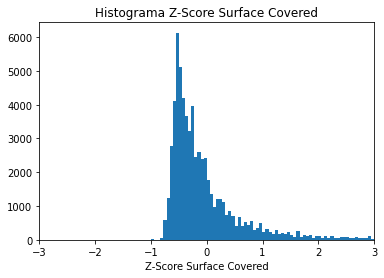

In [ ]:
plt.hist(train.z_surface_covered,bins=1000)
plt.title('Histograma Z-Score Surface Covered')
plt.xlabel('Z-Score Surface Covered')
plt.xlim(-3,3)
plt.show()

In [ ]:
train[(train.z_surface_covered < -3) | (train.z_surface_covered > 3)].shape

(918, 15)

In [ ]:
train[(train.z_surface_covered < -3) | (train.z_surface_covered > 3)].head()

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title,z_price,z_latitud,z_longitud,z_surface_total,z_surface_covered
23,-34.614981,-58.362643,Puerto Madero,Departamento,6,5,500.000000,470.0,2950000.0,DEPTO 6 AMB VENTA EN PUERTO MADERO ALEPH FAENA,9.459677,-0.691907,1.997561,0.278668,5.157261
40,-34.593098,-58.390295,Recoleta,Departamento,7,5,624.000000,624.0,1111111.0,"VENTA/ALQ piso 7 amb de estilo francés, 2 coch...",3.103151,0.133589,1.273165,0.367829,7.178210
62,-34.563353,-58.444035,Belgrano,Departamento,12,5,435.000000,435.0,850000.0,"Oportunidad retasada!!! Virrey Loreto 1700, 19...",2.200563,1.255670,-0.134618,0.231931,4.697954
75,-34.568032,-58.441285,Belgrano,Casa,6,5,550.000000,550.0,1580000.0,FANTASTICA CASA TOTALMENTE RECICLADA CON PILET...,4.723969,1.079147,-0.062599,0.314620,6.207105
165,-34.590568,-58.384887,Recoleta,Departamento,5,5,340.979624,310.0,980000.0,Departamento en Recoleta,2.649937,0.229006,1.414843,0.164328,3.057573


In [ ]:
train[(train.z_surface_covered < -3) | (train.z_surface_covered > 3)].tail()

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title,z_price,z_latitud,z_longitud,z_surface_total,z_surface_covered
64177,-34.573023,-58.419698,Palermo,Departamento,5,3,375.000000,337.0,1700000.0,PISO ALTO EN VENTA PALERMO 375 M2 5 AMB+2 COCH,5.138776,0.890880,0.502903,0.188789,3.411895
64245,-34.567085,-58.430604,Belgrano,Departamento,5,4,391.448769,359.0,2950000.0,Departamento en Belgrano,9.459677,1.114879,0.217217,0.200616,3.700602
64328,-34.592703,-58.388273,Recoleta,Departamento,6,4,315.000000,315.0,1190000.0,Departamento - Recoleta,3.375848,0.148482,1.326147,0.145647,3.123188
64408,-34.574864,-58.421311,Palermo,Departamento,5,3,400.000000,390.0,2844000.0,Piso en Venta Le Parc Demaría,9.093264,0.821410,0.460653,0.206765,4.107417
64625,-34.645319,-58.370902,Barracas,Casa,2,1,352.000000,352.0,300000.0,Casa - Barracas,0.299367,-1.836388,1.781202,0.172252,3.608741


Observando estos datos podemos verificar que los datos de surface_covered parecen ser logicos. Ademas, teniendo en cuenta que ya eliminamos de nuestro data set los casos atipicos de surface_total (que tiene 0,66 de correlacion con surface_covered), decidimos manterer en nuestro dataset estos "outliers".  


In [ ]:
train['z_rooms']=st.zscore(train.rooms)

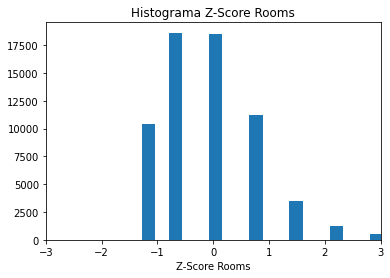

In [ ]:
plt.hist(train.z_rooms,bins=100)
plt.title('Histograma Z-Score Rooms')
plt.xlabel('Z-Score Rooms')
plt.xlim(-3,3)
plt.show()

In [ ]:
train[(train.z_rooms < -3) | (train.z_rooms > 3)].shape

(495, 16)

In [ ]:
train[(train.z_rooms < -3) | (train.z_rooms > 3)].rooms.value_counts()

8     225
9      89
10     73
11     32
12     25
14     15
15     12
13      7
16      3
20      3
17      2
18      2
19      2
28      1
30      1
24      1
35      1
32      1
Name: rooms, dtype: int64

Revisamos los valores que mas se alejan del z_score = 0:

In [ ]:
train[(train.rooms > 15)]

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title,z_price,z_latitud,z_longitud,z_surface_total,z_surface_covered,z_rooms
8626,-34.572580,-58.444946,Belgrano,Casa,16,11,791.081999,747.0,480000.0,Casa - Belgrano,0.921576,0.907596,-0.158484,0.487966,8.792345,9.326633
9946,-34.616391,-58.456038,Caballito,Departamento,30,2,79.000000,79.0,230000.0,C/DEP COCH Y BAULERA - SEGUI AL 700 - Caballito,0.057396,-0.745090,-0.449063,-0.024045,0.026149,19.225442
12140,-34.624766,-58.418918,Boedo,PH,20,14,1019.000000,1019.0,820000.0,Edificio ubicado en el Barrio de Boedo en Vent...,2.096861,-1.061053,0.523336,0.651847,12.361814,12.154864
12528,-34.642037,-58.438995,Parque Chacabuco,Departamento,35,26,37.000000,33.0,67000.0,Venta Departamento monoambiente balcón full am...,-0.506049,-1.712546,-0.002609,-0.054244,-0.577511,22.760731
14665,-34.611905,-58.382384,Monserrat,Departamento,18,17,554.000000,334.0,240000.0,Hotel en Venta - 17 habitaciones - Terraza Pro...,0.091963,-0.575900,1.480424,0.317496,3.372526,10.740749
25776,-34.616487,-58.371596,San Telmo,PH,24,22,800.000000,650.0,350000.0,Antiguo Ph para Hotel de Pasajeros 650m2,0.472203,-0.748711,1.763011,0.494378,7.519409,14.983095
29393,-34.618485,-58.377993,San Telmo,Departamento,16,16,992.958579,943.0,1300000.0,Departamento en San Telmo,3.756087,-0.824112,1.595447,0.633122,11.364463,9.326633
29575,-34.611413,-58.389221,Monserrat,Casa,17,16,585.000000,458.0,880000.0,IMPONENTE CASA 17 AMB CON TERRAZA VENTA MONSERRAT,2.304265,-0.557333,1.301321,0.339786,4.999784,10.033691
30655,-34.648922,-58.380522,Barracas,Casa,18,17,515.000000,515.0,135000.0,Casa sobre Lote Propio - A Refaccionar - Barracas,-0.270992,-1.972275,1.529202,0.289454,5.747798,10.740749
31360,-34.618485,-58.377993,San Telmo,Casa,16,16,992.958579,943.0,1300000.0,Casa en San Telmo,3.756087,-0.824112,1.595447,0.633122,11.364463,9.326633


Viendo el titulo de cada propiedad podemos concluir que estos potenciales "outliers" en realidad son datos coherentes. Cabe aclarar que hay algunos casos que si son outliers pero analizaremos mas adelante de forma multivariada. 

In [ ]:
train['z_bedrooms']=st.zscore(train.bedrooms)

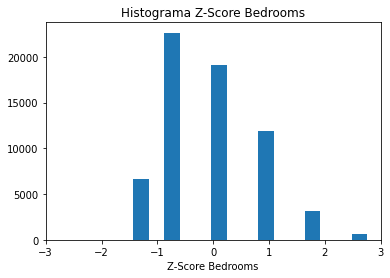

In [ ]:
plt.hist(train.z_bedrooms,bins=200)
plt.title('Histograma Z-Score Bedrooms')
plt.xlabel('Z-Score Bedrooms')
plt.xlim(-3,3)
plt.show()

In [ ]:
train[(train.z_bedrooms < -3) | (train.z_bedrooms > 3)].shape

(383, 17)

In [ ]:
train[(train.z_bedrooms < -3) | (train.z_bedrooms > 3)].bedrooms.value_counts()

6     171
7      72
8      46
10     22
9      17
12     14
11      9
16      6
14      6
13      3
17      3
32      3
15      3
22      2
18      2
70      1
20      1
26      1
30      1
Name: bedrooms, dtype: int64

In [ ]:
train[(train.bedrooms > 15)]

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title,z_price,z_latitud,z_longitud,z_surface_total,z_surface_covered,z_rooms,z_bedrooms
5663,-34.588454,-58.385257,Recoleta,Departamento,5,22,170.002520,144.0,430000.0,Departamento de 2 dormitorios con balcón en ve...,0.748740,0.308750,1.405148,0.041389,0.879147,1.548998,16.152358
10855,-34.646632,-58.497902,Villa Luro,Departamento,3,70,93.783811,70.0,135000.0,Departamento - Villa Luro,-0.270992,-1.885900,-1.545763,-0.013415,-0.091959,0.134883,54.519923
12528,-34.642037,-58.438995,Parque Chacabuco,Departamento,35,26,37.000000,33.0,67000.0,Venta Departamento monoambiente balcón full am...,-0.506049,-1.712546,-0.002609,-0.054244,-0.577511,22.760731,19.349655
14665,-34.611905,-58.382384,Monserrat,Departamento,18,17,554.000000,334.0,240000.0,Hotel en Venta - 17 habitaciones - Terraza Pro...,0.091963,-0.575900,1.480424,0.317496,3.372526,10.740749,12.155737
22680,-34.576061,-58.421289,Palermo,Departamento,3,20,127.000000,117.0,650000.0,Departamento - Palermo,1.509219,0.776259,0.461235,0.010469,0.524825,0.134883,14.553710
25776,-34.616487,-58.371596,San Telmo,PH,24,22,800.000000,650.0,350000.0,Antiguo Ph para Hotel de Pasajeros 650m2,0.472203,-0.748711,1.763011,0.494378,7.519409,14.983095,16.152358
29393,-34.618485,-58.377993,San Telmo,Departamento,16,16,992.958579,943.0,1300000.0,Departamento en San Telmo,3.756087,-0.824112,1.595447,0.633122,11.364463,9.326633,11.356413
29575,-34.611413,-58.389221,Monserrat,Casa,17,16,585.000000,458.0,880000.0,IMPONENTE CASA 17 AMB CON TERRAZA VENTA MONSERRAT,2.304265,-0.557333,1.301321,0.339786,4.999784,10.033691,11.356413
30655,-34.648922,-58.380522,Barracas,Casa,18,17,515.000000,515.0,135000.0,Casa sobre Lote Propio - A Refaccionar - Barracas,-0.270992,-1.972275,1.529202,0.289454,5.747798,10.740749,12.155737
31360,-34.618485,-58.377993,San Telmo,Casa,16,16,992.958579,943.0,1300000.0,Casa en San Telmo,3.756087,-0.824112,1.595447,0.633122,11.364463,9.326633,11.356413


Nuevamente, podemos observar que los valores parecen ser coherentes (exceptuando los casos que analizaremos posteriormente de forma multivariada)

Eliminamos las columnas que utilizamos para el anterior analisis:

In [ ]:
train = train.loc[:,~train.columns.str.startswith('z_')]
train.head()

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title
0,-34.601807,-58.469965,Paternal,Departamento,2,1,53.0,49.0,80000.0,Venta Depto 2 Amb c/balcon. Av San Martin.Pate...
1,-34.580088,-58.424965,Palermo,Departamento,2,1,35.0,35.0,79900.0,1 - Fray Justo Sta. Maria de Oro 2400
2,-34.551481,-58.452358,Belgrano,Departamento,1,1,25.0,20.0,69000.0,Venta depto mono ambiente Belgrano. Ugarte1500
3,-34.632290,-58.464844,Flores,Departamento,5,3,75.0,75.0,150000.0,VENTA 5 AMBIENTES CON BALCÓN EN FLORES!!
4,-34.549279,-58.463074,Nuñez,Departamento,2,1,46.0,34.0,85000.0,Departamento 2 ambientes con patio en venta - ...


In [ ]:
test = test.loc[:,~test.columns.str.startswith('z_')]
test.head()

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title
0,-34.598679,-58.499717,Villa del Parque,Departamento,1,0,38.0,28.0,85000.0,Departamento - Villa del Parque
1,-34.574987,-58.420611,Palermo,Departamento,2,1,150.0,70.0,520000.0,VENTA super RECICLADO depto 70 m2 cubiertos y ...
2,-34.600116,-58.390147,San Nicolás,Casa,5,3,123.0,187.0,780000.0,"CASA EN LOTE PROPIO, PB + 2 PISOS - CHALET COC..."
3,-34.581524,-58.403588,Palermo,Departamento,10,6,520.0,500.0,3300000.0,Venta Departamento Palermo
4,-34.615030,-58.431938,Caballito,Casa,6,5,227.0,466.0,830000.0,"CASA CON PILETA, PATIO Y TERRAZA"


### ● Análisis multivariado

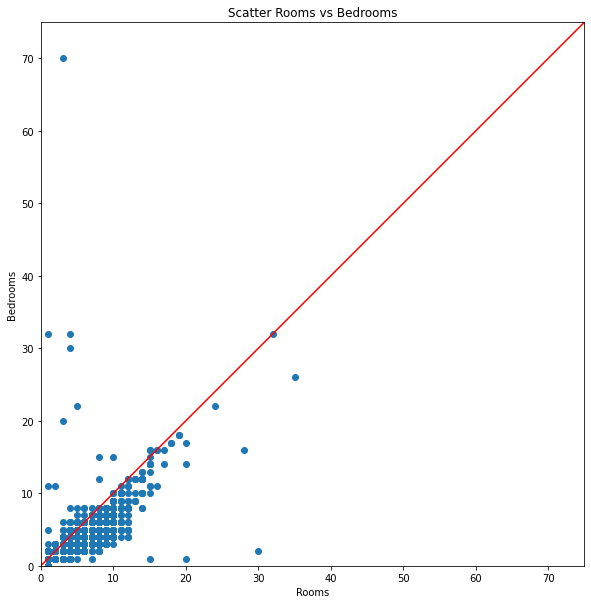

In [ ]:
x = train.rooms
y = train.bedrooms
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y)
plt.title('Scatter Rooms vs Bedrooms')
plt.xlabel('Rooms')
plt.ylabel('Bedrooms')
ax.set_aspect('equal')
ax.set_xlim((0, 75))
ax.set_ylim((0, 75))
ax.plot([0,1],[0,1], transform=ax.transAxes, color="red")
plt.show()

Notamos que hay propiedades que tienen mas bedrooms que rooms. Esto no tiene mucho sentido. Para confirmar si realemente son outliers haremos uso de isolation forest:

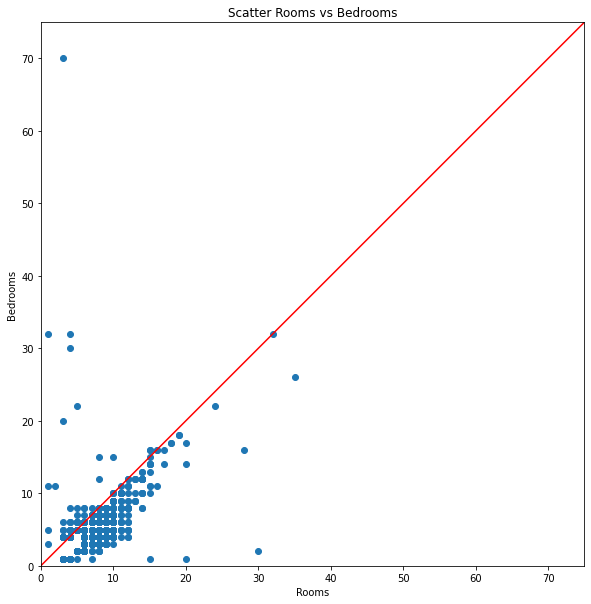

In [ ]:
iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                          contamination=0.05, max_features=2, 
                          bootstrap=False, n_jobs=-1, random_state=1)

df_isolation = train.copy()

pred = iforest.fit_predict(df_isolation[['rooms', 'bedrooms']])

df_isolation['outlier_label'] = pred
df_isolation['scores'] = iforest.decision_function(df_isolation[['rooms', 'bedrooms']])


x = df_isolation[df_isolation['outlier_label'] == -1].rooms
y = df_isolation[df_isolation['outlier_label'] == -1].bedrooms
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y)
plt.title('Scatter Rooms vs Bedrooms')
plt.xlabel('Rooms')
plt.ylabel('Bedrooms')
ax.set_aspect('equal')
ax.set_xlim((0, 75))
ax.set_ylim((0, 75))
ax.plot([0,1],[0,1], transform=ax.transAxes, color="red")
plt.show()

Notamos que el algoritmo encontro a las propiedades por encima de la recta y=x como outliers, corroborando nuestro pensamiento. Podemos ver que tambien detecto propiedades por debajo de la recta. Viendo mas detalladamente estos valores pensamos que no se tratan de outliers realmente sino de departamentos con muchos ambientes, lo cual es normal. 

In [ ]:
train = train[train['rooms'] >= train['bedrooms']]

train.shape

(64329, 10)

In [ ]:
test = test[test['rooms'] >= test['bedrooms']]

test.shape

(17193, 10)

Usamos Isolation Forest para encontrar outliers teniendo en cuenta las variables surface_covered y surface_total: 

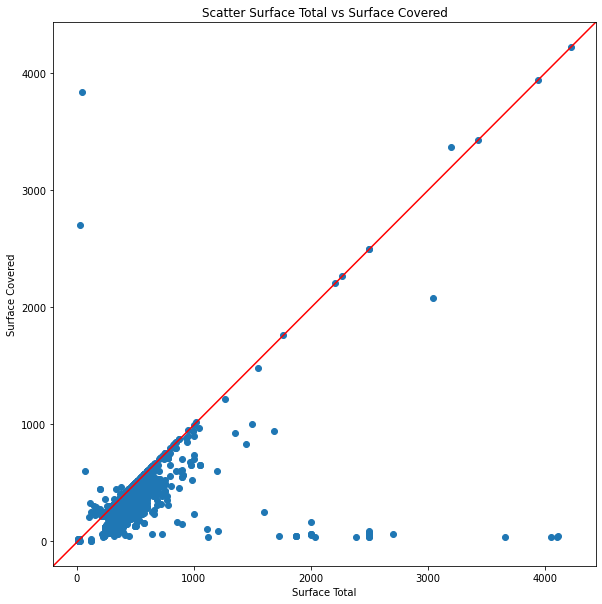

In [ ]:
iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                          contamination=0.05, max_features=2, 
                          bootstrap=False, n_jobs=-1, random_state=1)

df_isolation = train.copy()

pred = iforest.fit_predict(df_isolation[['surface_covered', 'surface_total']])

df_isolation['outlier_label'] = pred

x = df_isolation[df_isolation['outlier_label'] == -1].surface_total
y = df_isolation[df_isolation['outlier_label'] == -1].surface_covered
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y)
plt.title('Scatter Surface Total vs Surface Covered')
plt.xlabel('Surface Total')
plt.ylabel('Surface Covered')
ax.set_aspect('equal')

ax.plot([0,1],[0,1], transform=ax.transAxes, color="red")
plt.show()

Observamos los outliers mas detalladamente:

En principio, fuimos por el lado logico y nos dimos cuenta que una propiedad no puede tener un valor mas alto de surface_covered que de surface_total. Estas propiedades serian las siguientes:

In [ ]:
outliers = df_isolation[df_isolation['outlier_label'] == -1]

outliers[outliers['surface_covered'] >  outliers['surface_total']]

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title,outlier_label
341,-34.567172,-58.430634,Palermo,Departamento,5,4,377.0,400.000000,3200000.0,VENTA Torre M.R. Alvarez - LIBERTADOR 4444!!!...,-1
2225,-34.600608,-58.371484,Catalinas,Casa,6,5,380.0,384.000000,790000.0,Casa en Venta en Catalinas !,-1
2996,-34.547366,-58.451025,Nuñez,Casa,8,5,161.0,250.000000,520000.0,Casa de 8 amb en Venta Nuñez!Quincho Parrilla ...,-1
4180,-34.567172,-58.430634,Palermo,Departamento,5,4,377.0,400.000000,2700000.0,Venta Departamento - Palermo Nuevo - Libertado...,-1
7782,-34.627826,-58.411124,San Cristobal,Casa,5,3,149.0,305.000000,235000.0,VENTA CASA DE EPOCA 6 AMBIENTES MULTIFAMILIAR,-1
8772,-34.596675,-58.424455,Palermo,PH,6,5,200.0,450.000000,350000.0,Hermosa Propiedad con Techos muy altos y Pisos...,-1
14329,-34.588342,-58.388169,Recoleta,Departamento,4,3,271.0,300.000000,1800000.0,Departamento - Recoleta,-1
14752,-34.620660,-58.382698,Constitución,Departamento,7,5,440.0,444.000000,540000.0,Casa colonial con galería y jardín.,-1
19095,-34.630704,-58.400901,Parque Patricios,Departamento,1,0,31.0,2700.000000,71500.0,"DEPARTAMENTO - PQUE.PATRICIOS, 2 AMBIENTES, B...",-1
23568,-34.572494,-58.462433,Belgrano,Casa,5,4,3197.0,3367.000000,12000000.0,Casa - Belgrano R,-1


Mientras haciamos este analisis, observamos que hay muchas propiedades con un valor de surface_covered menor a 10 (en muchos casos igual a 1). Estas propiedades poseen muchas habitaciones con lo cual efectivamente son datos ilogicos. Los cuales procederemos a remover junto con los del anterior analisis.

In [ ]:
outliers[outliers['surface_covered'] < 10]

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title,outlier_label
1127,-34.572512,-58.478717,Villa Urquiza,Departamento,5,4,22.715015,1.0,598000.0,Departamento 5 Ambientes c/Dep. Sevicio!!! en ...,-1
2544,-34.583316,-58.496166,Villa Pueyrredón,PH,4,3,22.715015,1.0,280000.0,EXCELENTE PH 4 AMBIENTES IDEAL 2 FAMILIAS,-1
6893,-34.624678,-58.524197,Versalles,Casa,2,2,22.715015,1.0,290000.0,"Inmueble S/Lote de 8,66 x 35,90 y 33,25",-1
10696,-34.606251,-58.384552,San Nicolás,Departamento,1,1,22.715015,1.0,40548.0,Departamento 1 Ambiente a estrenar full amenit...,-1
12630,-34.585964,-58.515477,Villa Pueyrredón,PH,4,3,117.000000,1.0,215000.0,Duplex 4 ambientes o 3 ambientes más Play-room...,-1
14209,-34.667069,-58.472989,Villa Lugano,Departamento,3,2,22.715015,1.0,80000.0,VENTA HERMOSO DEPARTAMENTO EN BARRIO SAMORE,-1
14817,-34.573360,-58.441008,Belgrano,Departamento,3,2,22.715015,1.0,229000.0,3 Ambientes a estrenar c/ cochera y parrilla e...,-1
18724,-34.572512,-58.478717,Villa Urquiza,Departamento,5,4,22.715015,1.0,628000.0,Departamento 5 Ambientes c/Dep. Sevicio Terraz...,-1
20731,-34.633430,-58.480731,Floresta,PH,2,1,22.715015,1.0,52000.0,PH - Floresta,-1
22133,-34.610942,-58.490247,Villa del Parque,PH,3,2,22.715015,1.0,187000.0,Departamento Tipo Casa en Duplex al frente de ...,-1


In [ ]:
train = train[train['surface_total'] >= train['surface_covered']]

train = train[train['surface_covered'] > 10]

train.shape

(63847, 10)

In [ ]:
test = test[test['surface_total'] >= test['surface_covered']]

test = test[test['surface_covered'] > 10]

test.shape

(17063, 10)

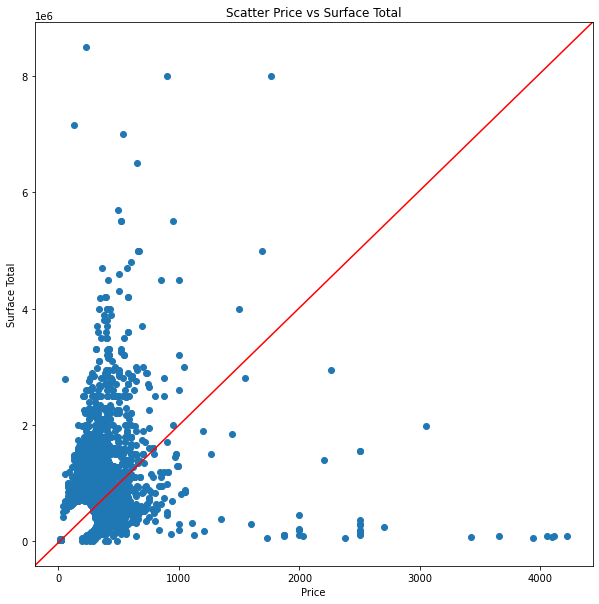

In [ ]:
iforest_price_surface = IsolationForest(n_estimators=100, max_samples='auto', 
                          contamination=0.05, max_features=2, 
                          bootstrap=False, n_jobs=-1, random_state=1)

df_isolation_price_forest = train.copy()

pred = iforest_price_surface.fit_predict(df_isolation_price_forest[['price', 'surface_total']])

df_isolation_price_forest['outlier_label'] = pred

x = df_isolation_price_forest[df_isolation_price_forest['outlier_label'] == -1].surface_total
y = df_isolation_price_forest[df_isolation_price_forest['outlier_label'] == -1].price
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y)
plt.title('Scatter Price vs Surface Total')
plt.xlabel('Price')
plt.ylabel('Surface Total')
# ax.set_aspect('equal')

ax.plot([0,1],[0,1], transform=ax.transAxes, color="red")
plt.show()

In [ ]:
outliers = df_isolation_price_forest[df_isolation_price_forest['outlier_label'] == -1]

outliers

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title,outlier_label
23,-34.614981,-58.362643,Puerto Madero,Departamento,6,5,500.000000,470.0,2950000.0,DEPTO 6 AMB VENTA EN PUERTO MADERO ALEPH FAENA,-1
24,-34.589588,-58.431352,Palermo,Casa,5,3,290.000000,230.0,815000.0,Impecable Casa en Calle Serrano 5 amb . 290 me...,-1
25,-34.592287,-58.384295,Recoleta,Departamento,5,4,254.000000,245.0,750000.0,1 - Libertad 1300,-1
40,-34.593098,-58.390295,Recoleta,Departamento,7,5,624.000000,624.0,1111111.0,"VENTA/ALQ piso 7 amb de estilo francés, 2 coch...",-1
51,-34.594751,-58.393546,Recoleta,Departamento,5,4,270.000000,265.0,669000.0,PISO 26 y 27 VISTA INCREÍBLE AL RÍO - 270 m2 ...,-1
...,...,...,...,...,...,...,...,...,...,...,...
64538,-34.578844,-58.406734,Palermo,Departamento,4,3,260.640985,232.0,730000.0,Muy lindo departamento en Edificio Francés,-1
64571,-34.603226,-58.524025,Villa Devoto,PH,4,3,316.000000,102.0,180000.0,VENTA PH A RECICLAR 4 AMBIENTES VILLA DEVOTO,-1
64577,-34.578914,-58.505478,Villa Pueyrredón,Casa,5,4,555.000000,300.0,495000.0,Casa - Villa Pueyrredon,-1
64596,-34.552132,-58.438501,Belgrano,Departamento,4,3,224.000000,211.0,1250000.0,Torre Forum alcorta 3 dormitorios playroom 3 c...,-1


Notamos que el metodo de Isolation Forest detecta outliers. Sin embargo, si miramos detenidamente cada propiedad, estos no parecen serlo. Simplemente, se esta tratando de propiedades cuyo valor es muy alto o se diferencia del resto, lo cual es posible ya que los precios de las propiedades no solo dependen de su cantidad de metros sino tambien de la zona en la que se encuentra. 

A continuacion, procederemos a eliminar la columna title, la cual fue de gran utilidad para el analisis de valores atipicos pero que no tiene mucho valor para el analisis posterior:

In [ ]:
train.drop('title', axis='columns', inplace=True)
train.head()

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price
0,-34.601807,-58.469965,Paternal,Departamento,2,1,53.0,49.0,80000.0
1,-34.580088,-58.424965,Palermo,Departamento,2,1,35.0,35.0,79900.0
2,-34.551481,-58.452358,Belgrano,Departamento,1,1,25.0,20.0,69000.0
3,-34.632290,-58.464844,Flores,Departamento,5,3,75.0,75.0,150000.0
4,-34.549279,-58.463074,Nuñez,Departamento,2,1,46.0,34.0,85000.0


In [ ]:
test.drop('title', axis='columns', inplace=True)
test.head()

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price
0,-34.598679,-58.499717,Villa del Parque,Departamento,1,0,38.0,28.0,85000.0
1,-34.574987,-58.420611,Palermo,Departamento,2,1,150.0,70.0,520000.0
3,-34.581524,-58.403588,Palermo,Departamento,10,6,520.0,500.0,3300000.0
5,-34.586527,-58.398279,Palermo,Departamento,2,1,43.0,41.0,87000.0
6,-34.577647,-58.406064,Palermo,Departamento,4,3,130.0,118.0,690000.0


## d) ◆ Reducción de la dimensionalidad

Empezamos por reducir las variables rooms y bedrooms:

In [ ]:
columns = ['rooms', 'bedrooms']

x_pca_train_rooms_bedrooms = train.loc[:, columns].values
scaler_pca_rooms_bedrooms = StandardScaler().fit(x_pca_train_rooms_bedrooms)
x_pca_train_rooms_bedrooms = scaler_pca_rooms_bedrooms.transform(x_pca_train_rooms_bedrooms)

In [ ]:
pca = PCA(n_components=2, random_state=700)
x_transformed = pca.fit_transform(x_pca_train_rooms_bedrooms)

In [ ]:
explained_variance = pca.explained_variance_ratio_

In [ ]:
explained_variance.cumsum()

array([0.97039129, 1.        ])

In [ ]:
pca.get_covariance()

array([[1.00001566, 0.94079732],
       [0.94079732, 1.00001566]])

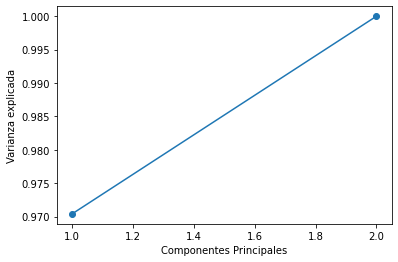

In [ ]:
list_x = list(range(1, len(explained_variance)+1))

# Grafico varianza explicada y cantidad de componentes principales
plt.figure(figsize=(6, 4))
plt.plot(list_x, explained_variance.cumsum(), '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Varianza explicada')
plt.show()

Viendo el grafico notamos que ya con 1 componente principal, tenemos mas de un 95% de varianza explicada. Por lo que con esta cantidad podriamos visualizar la misma informacion de los datos. 

In [ ]:
room_bedroom_pca = PCA(n_components=1)
room_bedroom_pca_transform_train = room_bedroom_pca.fit_transform(x_pca_train_rooms_bedrooms)
room_bedroom_pca_transform_train

array([[-0.88020103],
       [-0.88020103],
       [-1.38192557],
       ...,
       [ 0.21680951],
       [-0.88020103],
       [-0.88020103]])

Aplicamos lo mismo para surface_total y surface_covered:

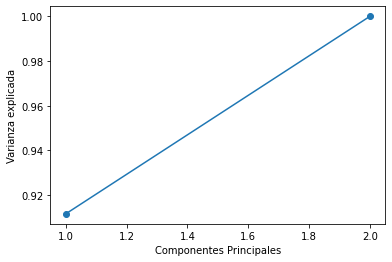

In [ ]:
columns = ['surface_covered', 'surface_total']

x_pca_train_surface = train.loc[:, columns].values
scaler_pca_surface = StandardScaler().fit(x_pca_train_surface)
x_pca_train_surface = scaler_pca_surface.transform(x_pca_train_surface)

pca = PCA(n_components=2)
x_transformed = pca.fit_transform(x_pca_train_surface)

explained_variance = pca.explained_variance_ratio_

list_x = list(range(1, len(explained_variance)+1))

plt.figure(figsize=(6, 4))
plt.plot(list_x, explained_variance.cumsum(), '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Varianza explicada')
plt.show()

In [ ]:
surface_pca = PCA(n_components=1, random_state=701)
surface_pca_transform_train=surface_pca.fit_transform(x_pca_train_surface)
surface_pca_transform_train

array([[-0.5465935 ],
       [-0.80998179],
       [-1.02662466],
       ...,
       [ 0.08705332],
       [-0.39275134],
       [-0.36547806]])

Aplicamos lo mismo para el dataset de test, usando el modelo de pca entrenado con los datos de train:

In [ ]:
columns = ['rooms', 'bedrooms']

x_pca_test_rooms_bedrooms = test.loc[:, columns].values
x_pca_test_rooms_bedrooms = scaler_pca_rooms_bedrooms.transform(x_pca_test_rooms_bedrooms)
room_bedroom_pca_transform_test = room_bedroom_pca.transform(x_pca_test_rooms_bedrooms)

room_bedroom_pca_transform_test

array([[-1.97721156],
       [-0.88020103],
       [ 6.11002527],
       ...,
       [-0.88020103],
       [ 0.21680951],
       [ 1.31382004]])

In [ ]:
columns = ['surface_covered', 'surface_total']

x_pca_test_surface = test.loc[:, columns].values
x_pca_test_surface = scaler_pca_surface.transform(x_pca_test_surface)
surface_pca_transform_test = surface_pca.transform(x_pca_test_surface)

surface_pca_transform_test

array([[-0.85695371],
       [ 0.34270189],
       [ 7.14147971],
       ...,
       [-0.67657922],
       [-0.13203893],
       [ 1.91016665]])

Generamos los nuevos datasets (train y test):

In [ ]:
train_reduced = train.drop(['rooms', 'bedrooms', 'surface_covered'], axis='columns')
train_reduced['pc_room_bedroom'] = room_bedroom_pca_transform_train
train_reduced['pc_surface'] = surface_pca_transform_train

train_reduced.reset_index(drop=True, inplace=True)

train_reduced

,latitud,longitud,neighborhood,type,surface_total,price,pc_room_bedroom,pc_surface
0,-34.601807,-58.469965,Paternal,Departamento,53.0,80000.0,-0.880201,-0.546594
1,-34.580088,-58.424965,Palermo,Departamento,35.0,79900.0,-0.880201,-0.809982
2,-34.551481,-58.452358,Belgrano,Departamento,25.0,69000.0,-1.381926,-1.026625
3,-34.632290,-58.464844,Flores,Departamento,75.0,150000.0,1.815545,-0.138132
4,-34.549279,-58.463074,Nuñez,Departamento,46.0,85000.0,-0.880201,-0.742056
...,...,...,...,...,...,...,...,...
63842,-34.631023,-58.370512,Barracas,Departamento,36.0,70000.0,-1.977212,-0.832130
63843,-34.557490,-58.463914,Belgrano,Departamento,75.0,158000.0,0.216810,-0.138132
63844,-34.628714,-58.413872,Boedo,Departamento,100.0,175000.0,0.216810,0.087053
63845,-34.587318,-58.452157,Chacarita,Departamento,61.0,122000.0,-0.880201,-0.392751


In [ ]:
test_reduced = test.drop(['rooms', 'bedrooms', 'surface_covered'], axis='columns')
test_reduced['pc_room_bedroom'] = room_bedroom_pca_transform_test
test_reduced['pc_surface'] = surface_pca_transform_test

test_reduced.reset_index(drop=True, inplace=True)

test_reduced

,latitud,longitud,neighborhood,type,surface_total,price,pc_room_bedroom,pc_surface
0,-34.598679,-58.499717,Villa del Parque,Departamento,38.0,85000.0,-1.977212,-0.856954
1,-34.574987,-58.420611,Palermo,Departamento,150.0,520000.0,-0.880201,0.342702
2,-34.581524,-58.403588,Palermo,Departamento,520.0,3300000.0,6.110025,7.141480
3,-34.586527,-58.398279,Palermo,Departamento,43.0,87000.0,-0.880201,-0.695084
4,-34.577647,-58.406064,Palermo,Departamento,130.0,690000.0,1.313820,0.668829
...,...,...,...,...,...,...,...,...
17058,-34.618986,-58.461856,Flores,Departamento,76.0,152000.0,0.216810,-0.228432
17059,-34.572933,-58.481700,Villa Urquiza,Departamento,46.0,109000.0,-0.880201,-0.673903
17060,-34.587750,-58.406649,Barrio Norte,Departamento,47.0,194000.0,-0.880201,-0.676579
17061,-34.621437,-58.399588,San Cristobal,Departamento,80.0,142000.0,0.216810,-0.132039


In [ ]:
train_reduced.head()

,latitud,longitud,neighborhood,type,surface_total,price,pc_room_bedroom,pc_surface
0,-34.601807,-58.469965,Paternal,Departamento,53.0,80000.0,-0.880201,-0.546594
1,-34.580088,-58.424965,Palermo,Departamento,35.0,79900.0,-0.880201,-0.809982
2,-34.551481,-58.452358,Belgrano,Departamento,25.0,69000.0,-1.381926,-1.026625
3,-34.632290,-58.464844,Flores,Departamento,75.0,150000.0,1.815545,-0.138132
4,-34.549279,-58.463074,Nuñez,Departamento,46.0,85000.0,-0.880201,-0.742056


# [2] ★ Agrupamiento

En este punto se busca analizar si es posible agrupar los datos en función de algún criterio. Para
esta tarea utilizar el algoritmo K-Means y se deberán realizar los siguientes puntos:

* Analizar la tendencia al clustering del dataset.
* Estimar la cantidad apropiada de grupos que se deben formar.
* Evaluar la calidad de los grupos formados realizando un análisis de Silhouette.
* Realizar un análisis de cada grupo intentando entender en función de qué
características fueron formados.
* Graficar sobre un mapa de CABA los avisos coloreados según el grupo al que
pertenecen.
* Repetir el análisis anterior, utilizando sólo 3 grupos.

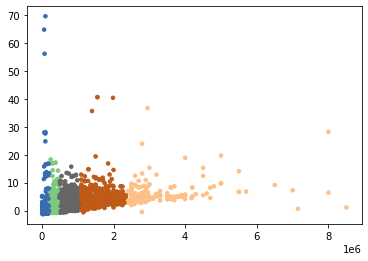

In [ ]:
train_price_pc_surface = train_reduced[['price', 'pc_surface']]

kmeans = KMeans(5, random_state=2456)

labels = kmeans.fit_predict(train_price_pc_surface)

plt.scatter(train_price_pc_surface["price"], train_price_pc_surface["pc_surface"], c=labels,
            s=50, cmap="Accent",marker=".")
plt.show()


### ● Análisis de tendencia al clustering

In [ ]:
hopkins(train_price_pc_surface,train_price_pc_surface.shape[0])

0.0005558115644974588

Podemos ver que la tendencia a clustering nos dio muy baja.

En cambio si usamos la latitud y longitud para separar en clusters, notamos que la tendendia a clustering aumenta significativamente y que estos mismos podrian representar los distintos barrios:

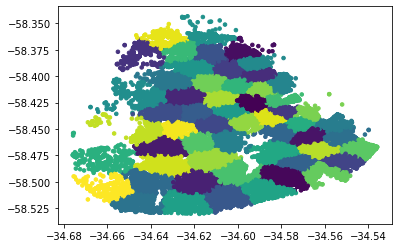

In [ ]:
train_lat_lng = train_reduced[['latitud', 'longitud']]

kmeans = KMeans(len(train_reduced.neighborhood.unique()), random_state=2456)

labels_lat_lng = kmeans.fit_predict(train_lat_lng)

plt.scatter(train_lat_lng["latitud"], train_lat_lng["longitud"], c=labels_lat_lng,
            s=50, cmap='viridis',marker=".")
plt.show()

In [ ]:
hopkins(train_lat_lng,train_lat_lng.shape[0])

0.01843856500649107

### ● Estimación de cantidad de clusters

Igualmente, vamos a seguir analizando el caso de las variables price y pc_surface.

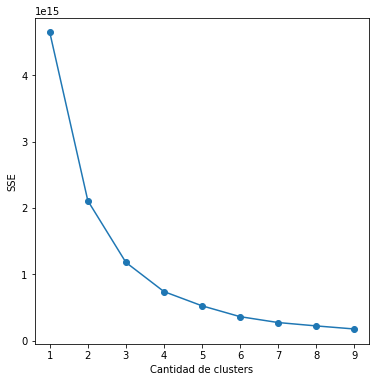

In [ ]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(train_price_pc_surface)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

### ● Calidad de clusters con Silhouette

Analizamos silhouette score:

In [ ]:
list_k = list(range(2, 6))

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(train_price_pc_surface)

    score = silhouette_score (train_price_pc_surface, preds)
    print ("For n_clusters = " + str(n_clusters) + " silhouette score is " + str(score))

For n_clusters = 2 silhouette score is 0.8722819724294875
For n_clusters = 3 silhouette score is 0.7765233010100239
For n_clusters = 4 silhouette score is 0.7037850352759212
For n_clusters = 5 silhouette score is 0.6459910799895859


Una vez utilizada la regla del codo y el coeficiente de silhouette podemos estimar que la cantidad de clusters más apropiada es k=2.

### ● Análisis de características de clusters

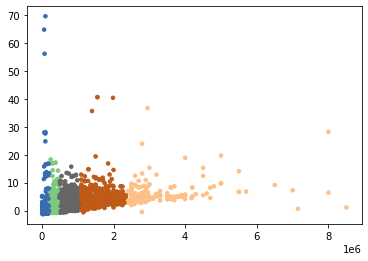

In [ ]:
plt.scatter(train_price_pc_surface["price"], train_price_pc_surface["pc_surface"], c=labels,
            s=50, cmap='Accent',marker=".")
plt.show()

Viendo el gráfico podemos observar que los clusters fueron formados a partir de la características del precio. Ya que si vemos el eje X (el cual pertenece al precio), ahí es donde se producen los cortes que forman estos clusters.

### ● Realizamos análisis para k=3 y graficamos en CABA

Repetimos el análisis pero ahora utilizando como hiperparámetro ***k=3***

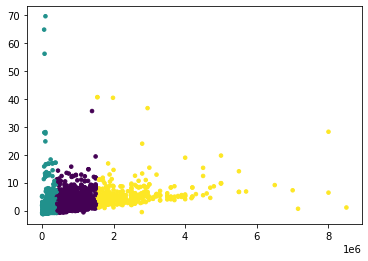

In [ ]:
train_price_pc_surface = train_reduced[['price', 'pc_surface']]

kmeans = KMeans(3, random_state=2456)

labels_k3 = kmeans.fit_predict(train_price_pc_surface)

plt.scatter(train_price_pc_surface["price"], train_price_pc_surface["pc_surface"], c=labels_k3,
            s=50, cmap='viridis',marker=".")
plt.show()

Analizamos la tendencia al clustering con k=3

In [ ]:
hopkins(train_price_pc_surface,train_price_pc_surface.shape[0])

0.0005573206123447311

El análisis de cantidad óptima de clusters es el mismo. 

Nuevamente en este caso los clusters fueron formados a partir de la característica precio, como vimos en el caso anterior.

Grafiquemos los clusters en CABA

In [ ]:
poly = gp.read_file(r'barrios.geojson')
poly.head()

,BARRIO,COMUNA,PERIMETRO,AREA,OBJETO,geometry
0,CHACARITA,15.0,7724.852955,3.115707e+06,BARRIO,"MULTIPOLYGON (((-58.45282 -34.59599, -58.45366..."
1,PATERNAL,15.0,7087.513295,2.229829e+06,BARRIO,"MULTIPOLYGON (((-58.46558 -34.59656, -58.46562..."
2,VILLA CRESPO,15.0,8131.857075,3.615978e+06,BARRIO,"MULTIPOLYGON (((-58.42375 -34.59783, -58.42495..."
3,VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06,BARRIO,"MULTIPOLYGON (((-58.49461 -34.61487, -58.49479..."
4,ALMAGRO,5.0,8537.901368,4.050752e+06,BARRIO,"MULTIPOLYGON (((-58.41287 -34.61412, -58.41282..."


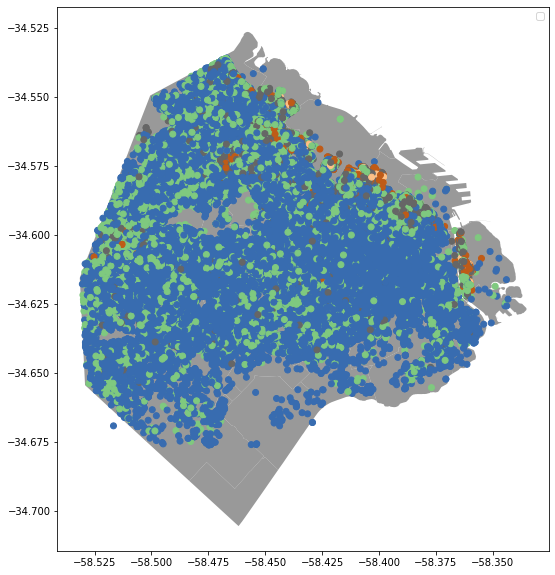

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
poly.plot(ax=ax,alpha=0.8, color="grey")
plt.scatter(train_reduced.longitud,train_reduced.latitud,c=labels, cmap="Accent")
ax.legend()

A partir de este gráfico podemos observar que la variedad de precios es bastante amplia a lo largo de todo CABA. Aunque, notamos que los precios más altos predominan en la zona costera.

Ahora observemos para k=3

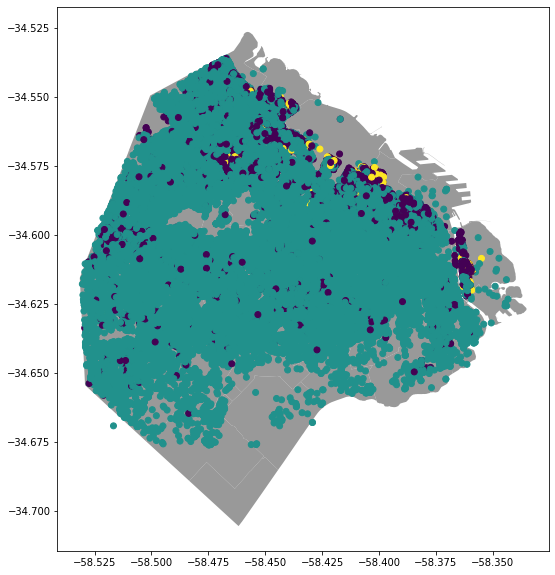

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
poly.plot(ax=ax,alpha=0.8, color="grey")
plt.scatter(train_reduced.longitud,train_reduced.latitud,c=labels_k3, cmap="viridis")

Podemos observar que la relación de precios es similar al caso anterior, pero con menos clusters.

# [3] ★ Clasificación

##a) ◆ Construcción del Target

### ● Distribución por metro cuadrado

In [ ]:
train_reduced.head()

,latitud,longitud,neighborhood,type,surface_total,price,pc_room_bedroom,pc_surface
0,-34.601807,-58.469965,Paternal,Departamento,53.0,80000.0,-0.880201,-0.546594
1,-34.580088,-58.424965,Palermo,Departamento,35.0,79900.0,-0.880201,-0.809982
2,-34.551481,-58.452358,Belgrano,Departamento,25.0,69000.0,-1.381926,-1.026625
3,-34.632290,-58.464844,Flores,Departamento,75.0,150000.0,1.815545,-0.138132
4,-34.549279,-58.463074,Nuñez,Departamento,46.0,85000.0,-0.880201,-0.742056


In [ ]:
train_reduced["pxm2"] = train_reduced.price/train_reduced.surface_total

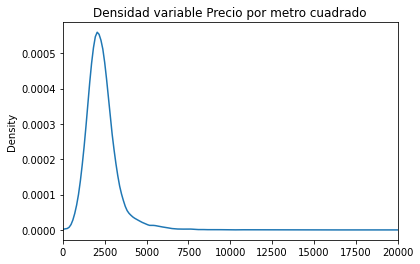

In [ ]:
train_reduced['pxm2'].plot.kde(title="Densidad variable Precio por metro cuadrado",xlabel="pxm2",ylabel="Densidad",xlim=(0,20000))

### ● Distribucion por metro cuadrado por propiedad

Text(0.5, 1.0, 'Densidad PH')

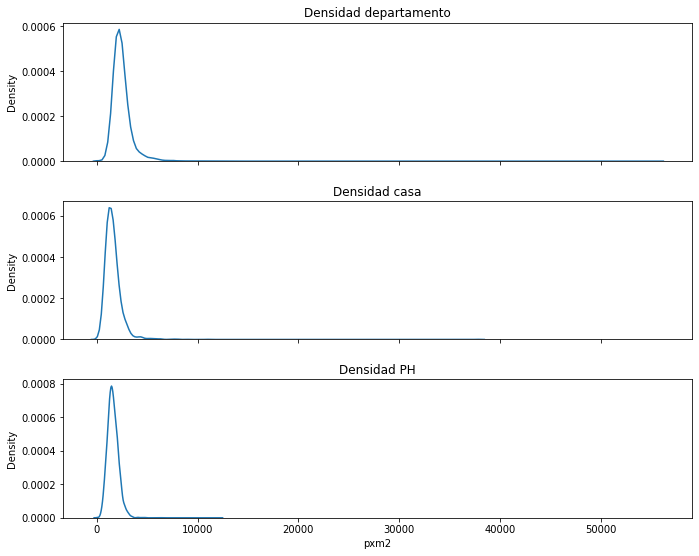

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10,8))
st = fig.suptitle("suptitle", fontsize="x-large")
fig.tight_layout(pad=3.0)
sns.kdeplot(ax=axes[0], data=train_reduced[train_reduced.type=="Departamento"]["pxm2"])
axes[0].set_title("Densidad departamento")
sns.kdeplot(ax=axes[1], data=train_reduced[train_reduced.type=="Casa"]["pxm2"])
axes[1].set_title("Densidad casa")
sns.kdeplot(ax=axes[2], data=train_reduced[train_reduced.type=="PH"]["pxm2"])
axes[2].set_title("Densidad PH")

In [ ]:
train_sorted = train_reduced.sort_values("pxm2")

### ● Distribuciones de precio por metro cuadrado segun criterios

Criterio #1


In [ ]:
first_train_sorted = train_sorted.copy()

In [ ]:
first_train_sorted["tipo_precio"]=""
third = ceil(len(first_train_sorted)/3)

In [ ]:
first_train_sorted.iloc[0:third]["tipo_precio"]="bajo"
first_train_sorted.iloc[third:third*2]["tipo_precio"]="medio"
first_train_sorted.iloc[third*2:]["tipo_precio"]="alto"

Text(0.5, 1.0, 'Densidad tipo_precio alto')

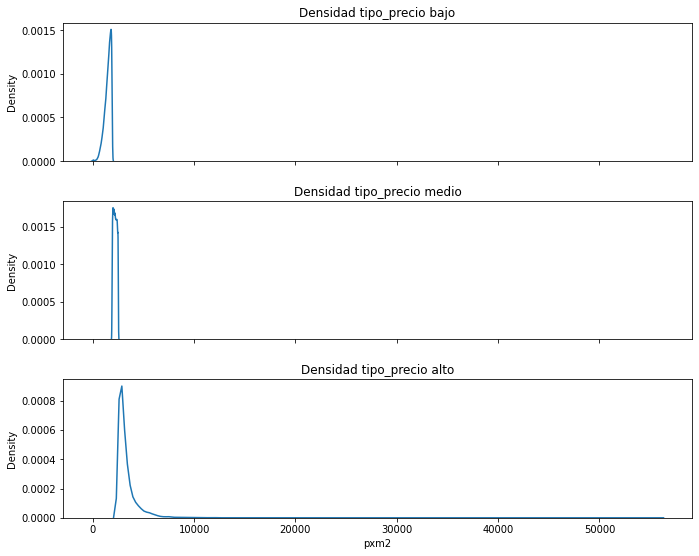

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10,8))
fig.tight_layout(pad=3.0)
sns.kdeplot(ax=axes[0], data=first_train_sorted[first_train_sorted.tipo_precio=="bajo"]["pxm2"])
axes[0].set_title("Densidad tipo_precio bajo")
sns.kdeplot(ax=axes[1], data=first_train_sorted[first_train_sorted.tipo_precio=="medio"]["pxm2"])
axes[1].set_title("Densidad tipo_precio medio")
sns.kdeplot(ax=axes[2], data=first_train_sorted[first_train_sorted.tipo_precio=="alto"]["pxm2"])
axes[2].set_title("Densidad tipo_precio alto")

Criterio #2

In [ ]:
second_train_sorted = train_sorted.copy()

In [ ]:
second_train_sorted["tipo_precio"]=""
fourth = ceil(len(second_train_sorted)/4)

In [ ]:
second_train_sorted.iloc[0:fourth]["tipo_precio"]="bajo"
second_train_sorted.iloc[fourth:fourth*3]["tipo_precio"]="medio"
second_train_sorted.iloc[fourth*3:]["tipo_precio"]="alto"

Text(0.5, 1.0, 'Densidad tipo_precio alto')

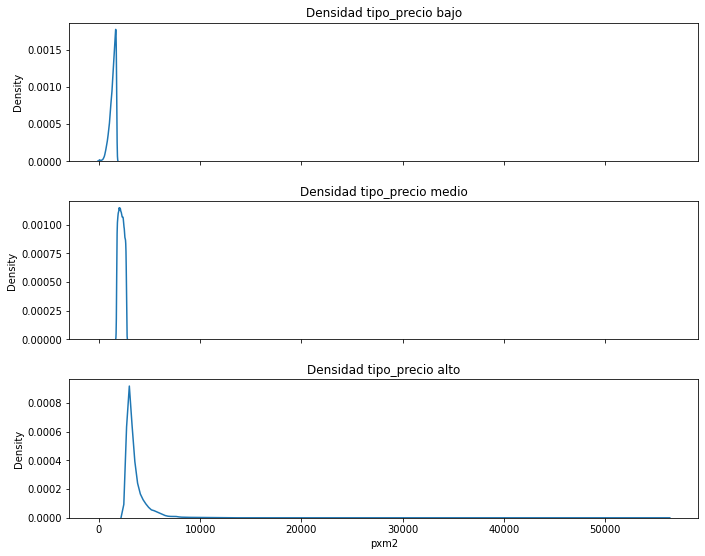

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10,8))
fig.tight_layout(pad=3.0)
sns.kdeplot(ax=axes[0], data=second_train_sorted[second_train_sorted.tipo_precio=="bajo"]["pxm2"])
axes[0].set_title("Densidad tipo_precio bajo")
sns.kdeplot(ax=axes[1], data=second_train_sorted[second_train_sorted.tipo_precio=="medio"]["pxm2"])
axes[1].set_title("Densidad tipo_precio medio")
sns.kdeplot(ax=axes[2], data=second_train_sorted[second_train_sorted.tipo_precio=="alto"]["pxm2"])
axes[2].set_title("Densidad tipo_precio alto")

Criterio #3

In [ ]:
train_departamento_sorted = train_sorted.loc[train_sorted["type"]=="Departamento"].copy()
train_casa_sorted = train_sorted.loc[train_sorted["type"]=="Casa"].copy()
train_ph_sorted = train_sorted.loc[train_sorted["type"]=="PH"].copy()

In [ ]:
fourth_departamento = ceil(len(train_departamento_sorted)/4)
fourth_casa = ceil(len(train_casa_sorted)/4)
fourth_ph = ceil(len(train_ph_sorted)/4)

In [ ]:
train_departamento_sorted["tipo_precio"] = ""
train_casa_sorted["tipo_precio"] = ""
train_ph_sorted["tipo_precio"] = ""

In [ ]:
train_departamento_sorted.iloc[0:fourth_departamento]["tipo_precio"]="bajo"
train_departamento_sorted.iloc[fourth_departamento:fourth_departamento*3]["tipo_precio"]="medio"
train_departamento_sorted.iloc[fourth_departamento*3:]["tipo_precio"]="alto"

In [ ]:
train_casa_sorted.iloc[0:fourth_casa]["tipo_precio"]="bajo"
train_casa_sorted.iloc[fourth_casa:fourth_casa*3]["tipo_precio"]="medio"
train_casa_sorted.iloc[fourth_casa*3:]["tipo_precio"]="alto"

In [ ]:
train_ph_sorted.iloc[0:fourth_ph]["tipo_precio"]="bajo"
train_ph_sorted.iloc[fourth_ph:fourth_ph*3]["tipo_precio"]="medio"
train_ph_sorted.iloc[fourth_ph*3:]["tipo_precio"]="alto"

In [ ]:
third_train_sorted = pd.concat([train_ph_sorted,train_casa_sorted,train_departamento_sorted])

Text(0.5, 1.0, 'Densidad tipo_precio alto')

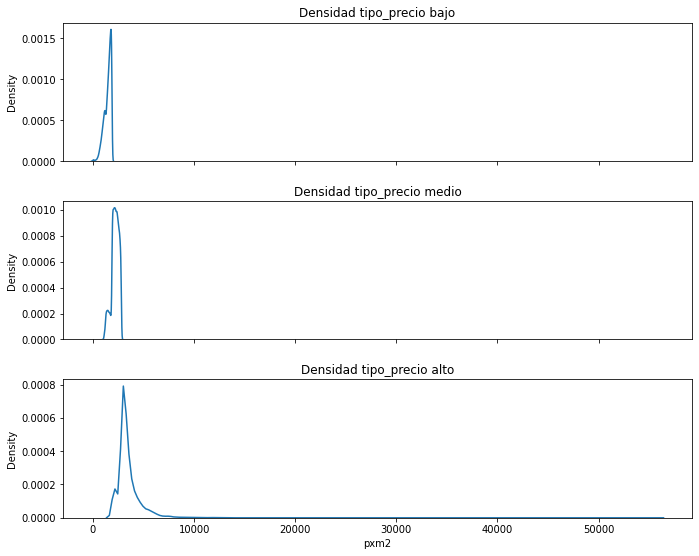

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10,8))
fig.tight_layout(pad=3.0)
sns.kdeplot(ax=axes[0], data=third_train_sorted[third_train_sorted.tipo_precio=="bajo"]["pxm2"])
axes[0].set_title("Densidad tipo_precio bajo")
sns.kdeplot(ax=axes[1], data=third_train_sorted[third_train_sorted.tipo_precio=="medio"]["pxm2"])
axes[1].set_title("Densidad tipo_precio medio")
sns.kdeplot(ax=axes[2], data=third_train_sorted[third_train_sorted.tipo_precio=="alto"]["pxm2"])
axes[2].set_title("Densidad tipo_precio alto")

Revisando los primer criterio de division encontramos que se distribuye de forma tal que hay precios que no son muy distintos pero que tienen una categoria de tipo_precio distinto.
En caso del criterio 2, parece una version mejorada del criterio 1, pero elegimos el criterio 3 dado a que tiene en cuenta el tipo de propiedad para establecer el tipo de precio.

### ● Gráfico del criterio elegido sobre mapa de CABA

In [ ]:
third_train_sorted.loc[third_train_sorted["tipo_precio"]=="bajo", "tipo_precio_target"]= 0
third_train_sorted.loc[third_train_sorted["tipo_precio"]=="medio", "tipo_precio_target"]= 1
third_train_sorted.loc[third_train_sorted["tipo_precio"]=="alto", "tipo_precio_target"]= 2
                                          

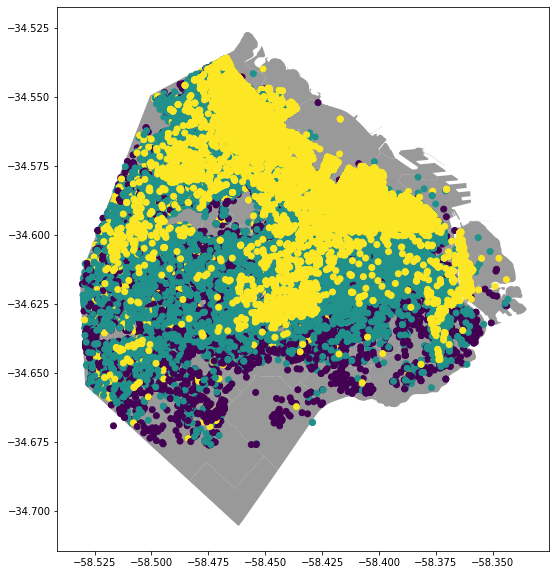

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
poly.plot(ax=ax,alpha=0.8, color="grey")
plt.scatter(third_train_sorted.longitud,third_train_sorted.latitud,c=third_train_sorted.tipo_precio_target, cmap="viridis")

In [ ]:
labels_k3.min()

0

In [ ]:
test_reduced["pxm2"] = test_reduced.price/test_reduced.surface_total
test_sorted = test_reduced.sort_values("pxm2")
test_departamento_sorted = test_sorted.loc[test_sorted["type"]=="Departamento"].copy()
test_casa_sorted = test_sorted.loc[test_sorted["type"]=="Casa"].copy()
test_ph_sorted = test_sorted.loc[test_sorted["type"]=="PH"].copy()

In [ ]:
fourth_departamento = ceil(len(test_departamento_sorted)/4)
fourth_casa = ceil(len(test_casa_sorted)/4)
fourth_ph = ceil(len(test_ph_sorted)/4)

In [ ]:
test_departamento_sorted["tipo_precio"] = ""
test_casa_sorted["tipo_precio"] = ""
test_ph_sorted["tipo_precio"] = ""

In [ ]:
test_departamento_sorted.iloc[0:fourth_departamento]["tipo_precio"]="bajo"
test_departamento_sorted.iloc[fourth_departamento:fourth_departamento*3]["tipo_precio"]="medio"
test_departamento_sorted.iloc[fourth_departamento*3:]["tipo_precio"]="alto"

test_casa_sorted.iloc[0:fourth_casa]["tipo_precio"]="bajo"
test_casa_sorted.iloc[fourth_casa:fourth_casa*3]["tipo_precio"]="medio"
test_casa_sorted.iloc[fourth_casa*3:]["tipo_precio"]="alto"

test_ph_sorted.iloc[0:fourth_ph]["tipo_precio"]="bajo"
test_ph_sorted.iloc[fourth_ph:fourth_ph*3]["tipo_precio"]="medio"
test_ph_sorted.iloc[fourth_ph*3:]["tipo_precio"]="alto"

third_test_sorted = pd.concat([train_ph_sorted,train_casa_sorted,train_departamento_sorted])

## b) ◆ Entrenamiento y Predicción

### ● Feature Engineering

In [ ]:
train_fe = pd.get_dummies(third_train_sorted, columns=['type'], drop_first=True)
test_fe = pd.get_dummies(third_test_sorted, columns=['type'], drop_first=True)

In [ ]:
train_fe

,latitud,longitud,neighborhood,surface_total,price,pc_room_bedroom,pc_surface,pxm2,tipo_precio,tipo_precio_target,type_Departamento,type_PH
36176,-34.594247,-58.397759,Recoleta,482.0,11111.0,8.304046,5.227797,23.051867,bajo,0.0,0,1
44123,-34.647545,-58.497062,Mataderos,132.0,11111.0,1.815545,0.361660,84.174242,bajo,0.0,0,1
12542,-34.617067,-58.513585,Villa Devoto,1208.0,170000.0,0.718534,8.007099,140.728477,bajo,0.0,0,1
1369,-34.645004,-58.407015,Parque Patricios,164.0,47000.0,1.313820,0.363656,286.585366,bajo,0.0,0,1
34778,-34.640883,-58.362774,Boca,195.0,58000.0,0.718534,1.098533,297.435897,bajo,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
63248,-34.610576,-58.361591,Puerto Madero,90.0,1200000.0,-0.880201,0.065132,13333.333333,alto,2.0,1,0
54061,-34.582825,-58.442826,Palermo,40.0,600000.0,-1.381926,-0.726001,15000.000000,alto,2.0,1,0
1351,-34.573416,-58.447945,Colegiales,53.0,1160600.0,-0.880201,-0.634218,21898.113208,alto,2.0,1,0
13627,-34.551243,-58.455105,Nuñez,56.0,2790000.0,-1.381926,-0.544885,49821.428571,alto,2.0,1,0


In [ ]:
le = LabelEncoder()
train_fe['neighborhood_encoded'] = le.fit_transform(train_fe['neighborhood'].astype(str))
test_fe['neighborhood_encoded'] = le.transform(test_fe['neighborhood'].astype(str))
train_fe

,latitud,longitud,neighborhood,surface_total,price,pc_room_bedroom,pc_surface,pxm2,tipo_precio,tipo_precio_target,type_Departamento,type_PH,neighborhood_encoded
36176,-34.594247,-58.397759,Recoleta,482.0,11111.0,8.304046,5.227797,23.051867,bajo,0.0,0,1,35
44123,-34.647545,-58.497062,Mataderos,132.0,11111.0,1.815545,0.361660,84.174242,bajo,0.0,0,1,21
12542,-34.617067,-58.513585,Villa Devoto,1208.0,170000.0,0.718534,8.007099,140.728477,bajo,0.0,0,1,45
1369,-34.645004,-58.407015,Parque Patricios,164.0,47000.0,1.313820,0.363656,286.585366,bajo,0.0,0,1,31
34778,-34.640883,-58.362774,Boca,195.0,58000.0,0.718534,1.098533,297.435897,bajo,0.0,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63248,-34.610576,-58.361591,Puerto Madero,90.0,1200000.0,-0.880201,0.065132,13333.333333,alto,2.0,1,0,34
54061,-34.582825,-58.442826,Palermo,40.0,600000.0,-1.381926,-0.726001,15000.000000,alto,2.0,1,0,26
1351,-34.573416,-58.447945,Colegiales,53.0,1160600.0,-0.880201,-0.634218,21898.113208,alto,2.0,1,0,14
13627,-34.551243,-58.455105,Nuñez,56.0,2790000.0,-1.381926,-0.544885,49821.428571,alto,2.0,1,0,24


In [ ]:
le_target = LabelEncoder()
train_fe['tipo_precio_encoded'] = le.fit_transform(train_fe['tipo_precio'].astype(str))
test_fe['tipo_precio_encoded'] = le.transform(test_fe['tipo_precio'].astype(str))

In [ ]:
y_train = train_fe["tipo_precio_encoded"].copy()
y_test = test_fe["tipo_precio_encoded"].copy()

In [ ]:
train_fe

,latitud,longitud,neighborhood,surface_total,price,pc_room_bedroom,pc_surface,pxm2,tipo_precio,tipo_precio_target,type_Departamento,type_PH,neighborhood_encoded,tipo_precio_encoded
36176,-34.594247,-58.397759,Recoleta,482.0,11111.0,8.304046,5.227797,23.051867,bajo,0.0,0,1,35,1
44123,-34.647545,-58.497062,Mataderos,132.0,11111.0,1.815545,0.361660,84.174242,bajo,0.0,0,1,21,1
12542,-34.617067,-58.513585,Villa Devoto,1208.0,170000.0,0.718534,8.007099,140.728477,bajo,0.0,0,1,45,1
1369,-34.645004,-58.407015,Parque Patricios,164.0,47000.0,1.313820,0.363656,286.585366,bajo,0.0,0,1,31,1
34778,-34.640883,-58.362774,Boca,195.0,58000.0,0.718534,1.098533,297.435897,bajo,0.0,0,1,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63248,-34.610576,-58.361591,Puerto Madero,90.0,1200000.0,-0.880201,0.065132,13333.333333,alto,2.0,1,0,34,0
54061,-34.582825,-58.442826,Palermo,40.0,600000.0,-1.381926,-0.726001,15000.000000,alto,2.0,1,0,26,0
1351,-34.573416,-58.447945,Colegiales,53.0,1160600.0,-0.880201,-0.634218,21898.113208,alto,2.0,1,0,14,0
13627,-34.551243,-58.455105,Nuñez,56.0,2790000.0,-1.381926,-0.544885,49821.428571,alto,2.0,1,0,24,0


In [ ]:
x_train = train_fe.drop(columns=["neighborhood", "surface_total", "price", "pxm2", "tipo_precio", "tipo_precio_target", "tipo_precio_encoded"])
x_test = test_fe.drop(columns=["neighborhood", "surface_total", "price", "tipo_precio", "pxm2", "tipo_precio_encoded"])

### - Modelo 1: Árbol de decisión

In [ ]:
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'ccp_alpha':np.linspace(0,0.05,n), 
               'max_depth':list(range(1,15))
                }
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 
scorer_fn = make_scorer(f1_score, average='micro')
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'max_depth': 9, 'criterion': 'gini', 'ccp_alpha': 0.0}
0.5702866592832964


In [ ]:
#Atributos considerados y su importancia
best_tree = randomcv.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,x_train.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))


type_PH: 0.00701828251451041
pc_room_bedroom: 0.012962735442090863
type_Departamento: 0.04575497420302414
neighborhood_encoded: 0.07849852946652744
pc_surface: 0.11092114241951058
longitud: 0.28633993990049467
latitud: 0.4585043960538419


In [ ]:
train.head()

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title
0,-34.601807,-58.469965,Paternal,Departamento,2,1,53.0,49.0,80000.0,Venta Depto 2 Amb c/balcon. Av San Martin.Pate...
1,-34.580088,-58.424965,Palermo,Departamento,2,1,35.0,35.0,79900.0,1 - Fray Justo Sta. Maria de Oro 2400
2,-34.551481,-58.452358,Belgrano,Departamento,1,1,25.0,20.0,69000.0,Venta depto mono ambiente Belgrano. Ugarte1500
3,-34.632290,-58.464844,Flores,Departamento,5,3,75.0,75.0,150000.0,VENTA 5 AMBIENTES CON BALCÓN EN FLORES!!
4,-34.549279,-58.463074,Nuñez,Departamento,2,1,46.0,34.0,85000.0,Departamento 2 ambientes con patio en venta - ...


Creamos el arbol de decision

In [ ]:

tree_model = tree.DecisionTreeClassifier(criterion="entropy",
                                         max_depth = 10, 
                                         min_samples_leaf=10,
                                         ccp_alpha=0.005555)
#Entrenamos el modelo
model = tree_model.fit(X = x_train, y = y_train)

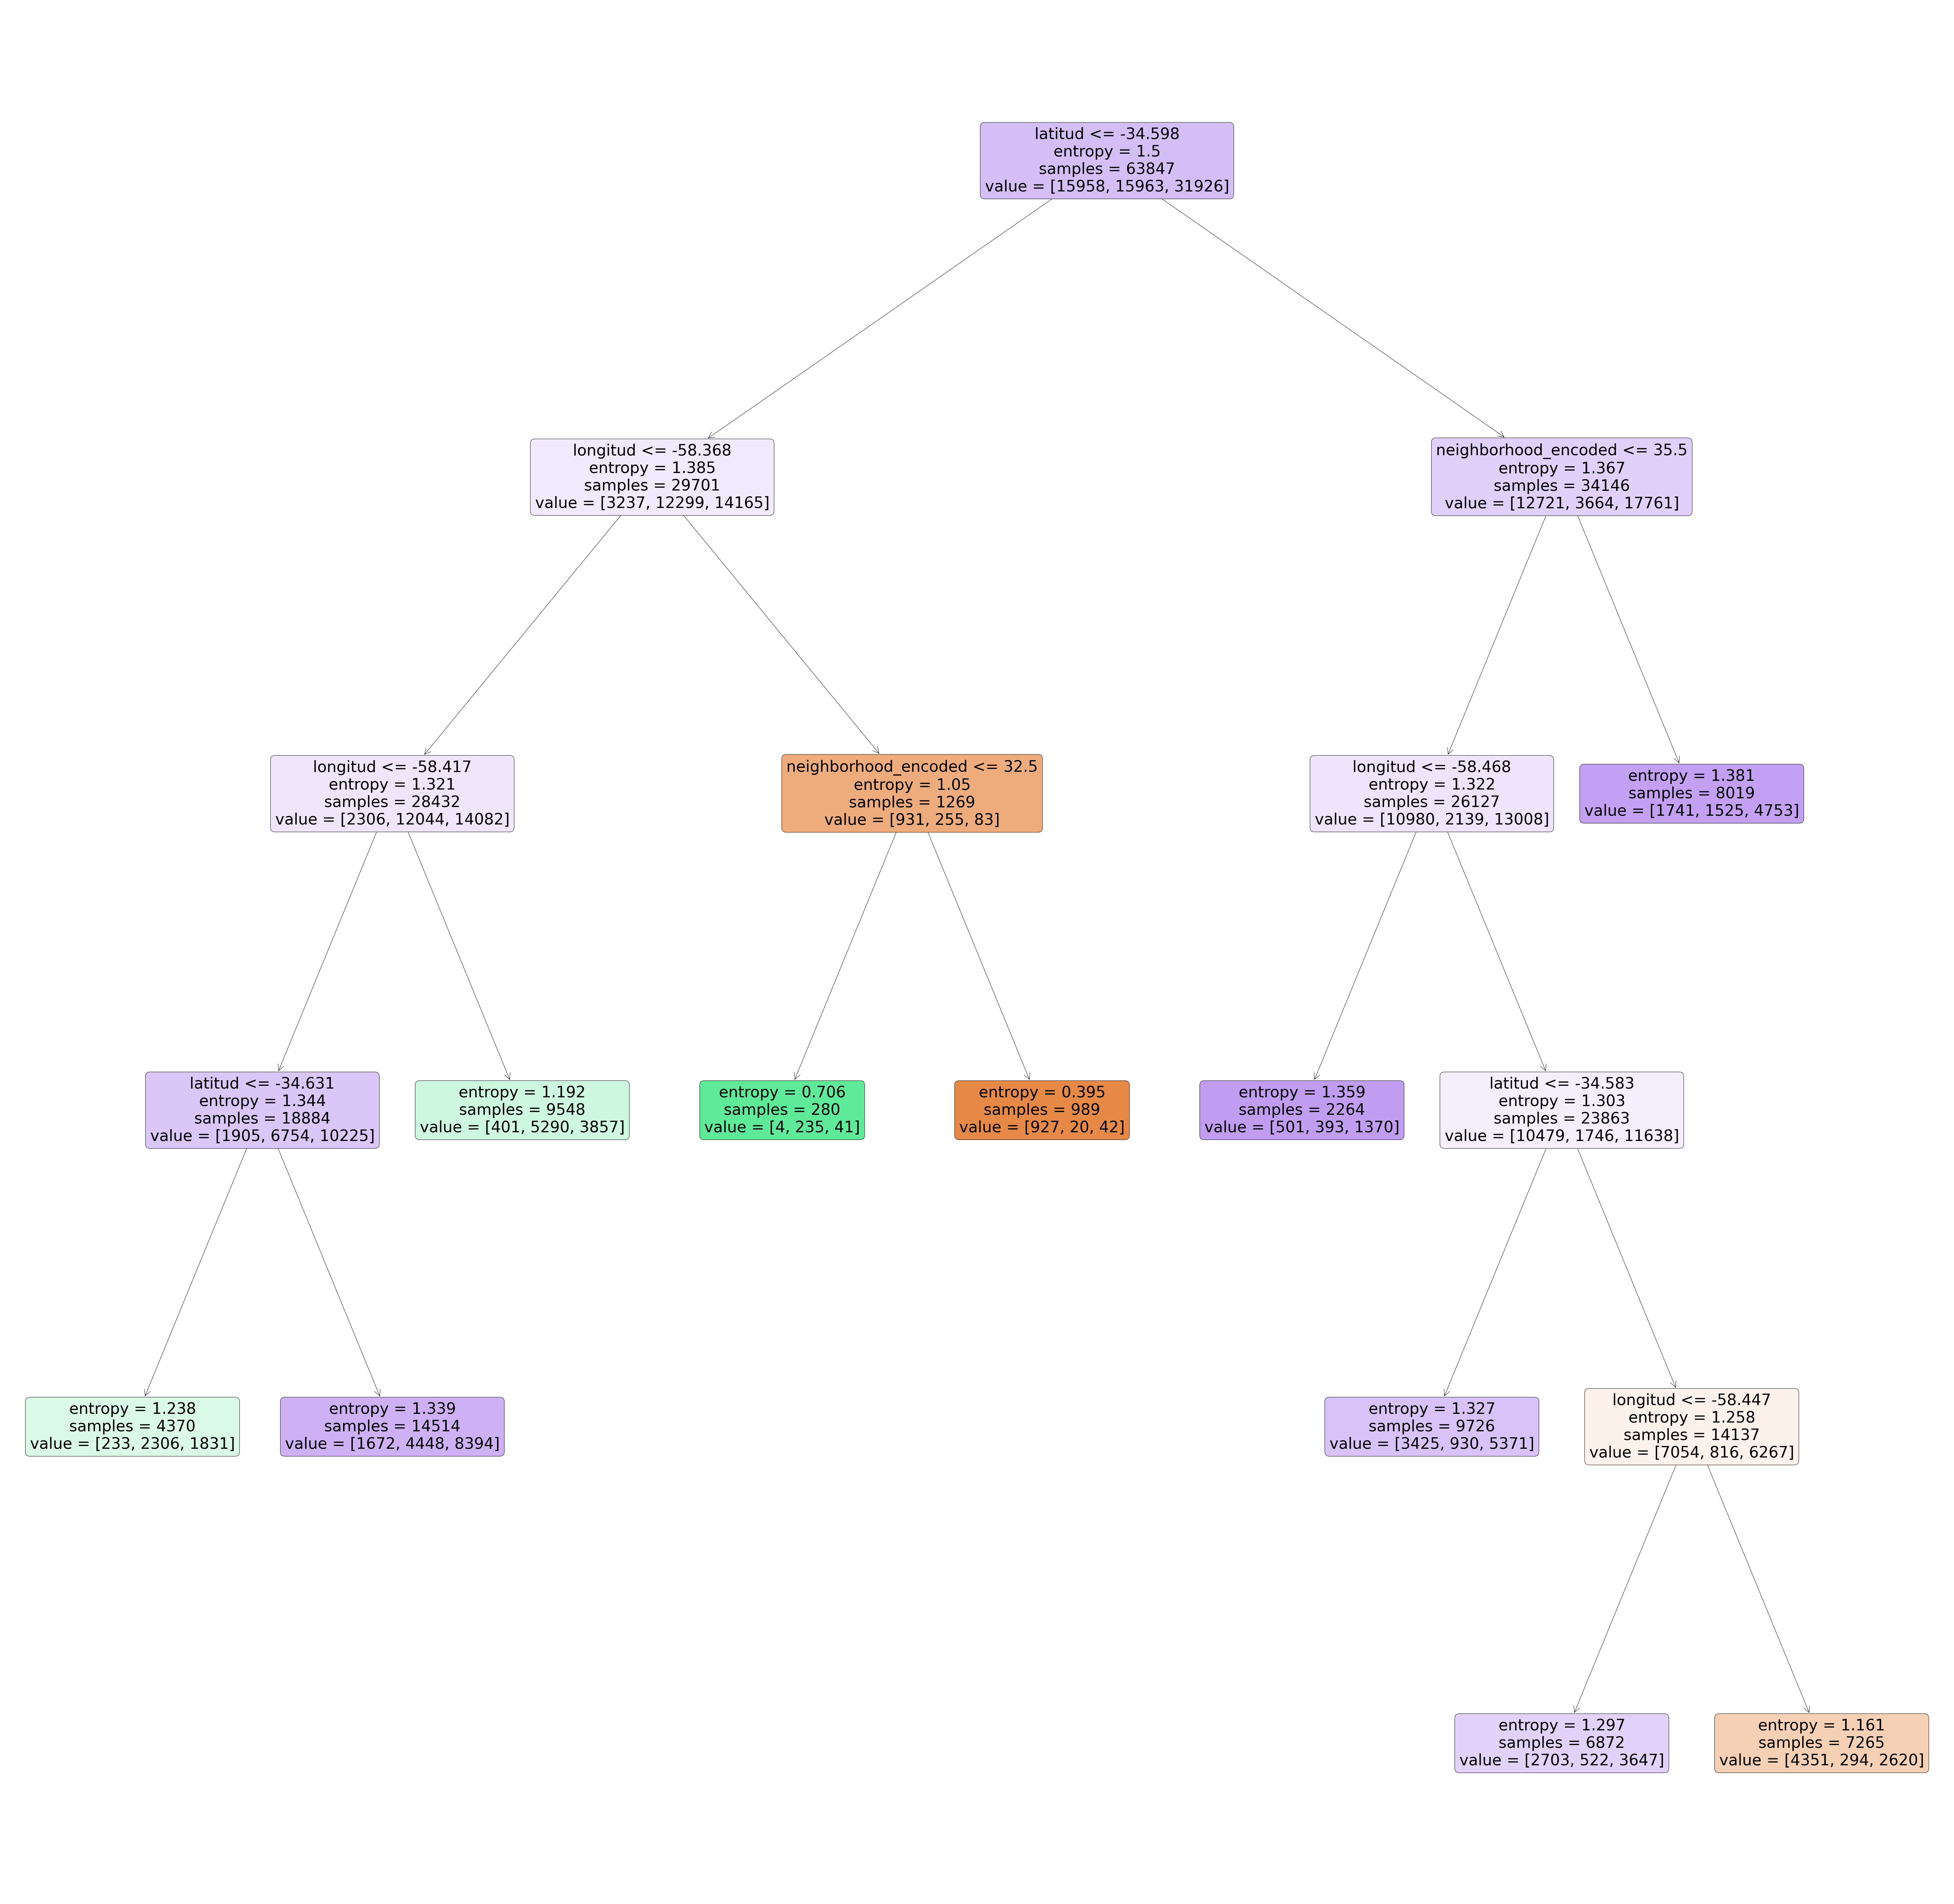

In [ ]:
plt.figure(figsize=(100,100))

tree_plot_completo=tree.plot_tree(model,
                                 feature_names=x_train.columns.to_list(),
                                 filled=True,
                                 rounded=True) #model.classes_
plt.show(tree_plot_completo)

In [ ]:
y_pred = model.predict(x_test)
#Valores Predichos
y_pred

array([2, 1, 2, ..., 2, 2, 0])

In [ ]:

accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred, average='weighted')
f1=f1_score(y_test,y_pred, average='weighted')
print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.5739345623130296
Recall: 0.5739345623130296
f1 score: 0.5598110042930012


In [ ]:
train["pxm2"]=train.price/train.surface_total
train_sorted=train.sort_values("pxm2")
train_sorted["tipo_precio"]=""
train_departamento_sorted = train_sorted.loc[train_sorted["type"]=="Departamento"].copy()
train_casa_sorted = train_sorted.loc[train_sorted["type"]=="Casa"].copy()
train_ph_sorted = train_sorted.loc[train_sorted["type"]=="PH"].copy()

In [ ]:
fourth_departamento = ceil(len(train_departamento_sorted)/4)
fourth_casa = ceil(len(train_casa_sorted)/4)
fourth_ph = ceil(len(train_ph_sorted)/4)

In [ ]:
train_departamento_sorted["tipo_precio"] = ""
train_casa_sorted["tipo_precio"] = ""
train_ph_sorted["tipo_precio"] = ""

In [ ]:
train_departamento_sorted.iloc[0:fourth_departamento]["tipo_precio"]="bajo"
train_departamento_sorted.iloc[fourth_departamento:fourth_departamento*3]["tipo_precio"]="medio"
train_departamento_sorted.iloc[fourth_departamento*3:]["tipo_precio"]="alto"

train_casa_sorted.iloc[0:fourth_casa]["tipo_precio"]="bajo"
train_casa_sorted.iloc[fourth_casa:fourth_casa*3]["tipo_precio"]="medio"
train_casa_sorted.iloc[fourth_casa*3:]["tipo_precio"]="alto"

train_ph_sorted.iloc[0:fourth_ph]["tipo_precio"]="bajo"
train_ph_sorted.iloc[fourth_ph:fourth_ph*3]["tipo_precio"]="medio"
train_ph_sorted.iloc[fourth_ph*3:]["tipo_precio"]="alto"

train_sorted = pd.concat([train_ph_sorted,train_casa_sorted,train_departamento_sorted])

In [ ]:
test.head()

,latitud,longitud,neighborhood,type,rooms,bedrooms,surface_total,surface_covered,price,title
0,-34.598679,-58.499717,Villa del Parque,Departamento,1,0,38.0,28.0,85000.0,Departamento - Villa del Parque
1,-34.574987,-58.420611,Palermo,Departamento,2,1,150.0,70.0,520000.0,VENTA super RECICLADO depto 70 m2 cubiertos y ...
3,-34.581524,-58.403588,Palermo,Departamento,10,6,520.0,500.0,3300000.0,Venta Departamento Palermo
5,-34.586527,-58.398279,Palermo,Departamento,2,1,43.0,41.0,87000.0,Departamento - Barrio Norte
6,-34.577647,-58.406064,Palermo,Departamento,4,3,130.0,118.0,690000.0,Departamento - Palermo Chico


In [ ]:
test["pxm2"]=test.price/test.surface_total
test_sorted=test.sort_values("pxm2")
test_sorted["tipo_precio"]=""
test_departamento_sorted = test_sorted.loc[test_sorted["type"]=="Departamento"].copy()
test_casa_sorted = test_sorted.loc[test_sorted["type"]=="Casa"].copy()
test_ph_sorted = test_sorted.loc[test_sorted["type"]=="PH"].copy()

In [ ]:
fourth_departamento = ceil(len(test_departamento_sorted)/4)
fourth_casa = ceil(len(test_casa_sorted)/4)
fourth_ph = ceil(len(test_ph_sorted)/4)

In [ ]:
test_departamento_sorted["tipo_precio"] = ""
test_casa_sorted["tipo_precio"] = ""
test_ph_sorted["tipo_precio"] = ""

In [ ]:
test_departamento_sorted.iloc[0:fourth_departamento]["tipo_precio"]="bajo"
test_departamento_sorted.iloc[fourth_departamento:fourth_departamento*3]["tipo_precio"]="medio"
test_departamento_sorted.iloc[fourth_departamento*3:]["tipo_precio"]="alto"

test_casa_sorted.iloc[0:fourth_casa]["tipo_precio"]="bajo"
test_casa_sorted.iloc[fourth_casa:fourth_casa*3]["tipo_precio"]="medio"
test_casa_sorted.iloc[fourth_casa*3:]["tipo_precio"]="alto"

test_ph_sorted.iloc[0:fourth_ph]["tipo_precio"]="bajo"
test_ph_sorted.iloc[fourth_ph:fourth_ph*3]["tipo_precio"]="medio"
test_ph_sorted.iloc[fourth_ph*3:]["tipo_precio"]="alto"

test_sorted = pd.concat([test_ph_sorted,test_casa_sorted,test_departamento_sorted])

In [ ]:
train_fe_not_reduced = pd.get_dummies(train_sorted, columns=['type'], drop_first=True)
test_fe_not_reduced = pd.get_dummies(test_sorted, columns=['type'], drop_first=True)

In [ ]:
le = LabelEncoder()
train_fe_not_reduced['neighborhood_encoded'] = le.fit_transform(train_fe_not_reduced['neighborhood'].astype(str))
test_fe_not_reduced['neighborhood_encoded'] = le.transform(test_fe_not_reduced['neighborhood'].astype(str))

le_target = LabelEncoder()
train_fe_not_reduced['tipo_precio_encoded'] = le.fit_transform(train_fe_not_reduced['tipo_precio'].astype(str))
test_fe_not_reduced['tipo_precio_encoded'] = le.transform(test_fe_not_reduced['tipo_precio'].astype(str))

In [ ]:
train_fe_not_reduced

,latitud,longitud,neighborhood,rooms,bedrooms,surface_total,surface_covered,price,title,pxm2,tipo_precio,type_Departamento,type_PH,neighborhood_encoded,tipo_precio_encoded
36678,-34.594247,-58.397759,Recoleta,12,8,482.0,331.0,11111.0,Petit Hotel en Venta con RENTA en Recoleta con...,23.051867,bajo,0,1,35,1
44727,-34.647545,-58.497062,Mataderos,5,3,132.0,85.0,11111.0,"PH 5 Ambientes, patio y terraza, Sin expensas ...",84.174242,bajo,0,1,21,1
12716,-34.617067,-58.513585,Villa Devoto,4,2,1208.0,90.0,170000.0,PH 3 AMB CON PATIO Y PLAYROOM Y TERRAZA DEVOTO,140.728477,bajo,0,1,45,1
1387,-34.645004,-58.407015,Parque Patricios,4,3,164.0,62.0,47000.0,PH 4 AMB C PATIO Y TERRAZA | RECICLAR,286.585366,bajo,0,1,31,1
35262,-34.640883,-58.362774,Boca,4,2,195.0,115.0,58000.0,PH 4 amb - Boca - OPORTUNIDAD,297.435897,bajo,0,1,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64112,-34.610576,-58.361591,Puerto Madero,2,1,90.0,85.0,1200000.0,"Venta ALVEAR ICON, piso alto, 90 mts c/coch y ...",13333.333333,alto,1,0,34,0
54808,-34.582825,-58.442826,Palermo,1,1,40.0,40.0,600000.0,6 Departamentos monoambientes con Balcon en Ve...,15000.000000,alto,1,0,26,0
1369,-34.573416,-58.447945,Colegiales,2,1,53.0,40.0,1160600.0,DEPTO DE POZO CUOTAS EN PESOS 2 AMBIENTES CON ...,21898.113208,alto,1,0,14,0
13817,-34.551243,-58.455105,Nuñez,1,1,56.0,47.0,2790000.0,Venta departamento 2 ambientes Nuñez Financio,49821.428571,alto,1,0,24,0


In [ ]:
y_train_not_reduced = train_fe_not_reduced["tipo_precio_encoded"].copy()
y_test_not_reduced = test_fe_not_reduced["tipo_precio_encoded"].copy()

In [ ]:
x_train_not_reduced = train_fe_not_reduced.drop(columns=["neighborhood", "surface_total", "price", "pxm2", "tipo_precio", "tipo_precio_encoded"])
x_test_not_reduced = test_fe_not_reduced.drop(columns=["neighborhood", "surface_total", "price", "tipo_precio", "pxm2", "tipo_precio_encoded"])

In [ ]:
#Kfold estratificado
kfoldcv_nr = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree_nr = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn_nr = make_scorer(f1_score, average='micro')

#Random Search Cross Validation
randomcv_nr = RandomizedSearchCV(estimator=base_tree_nr,
                              param_distributions = params_grid,
                              scoring=scorer_fn_nr,
                              cv=kfoldcv_nr,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv_nr.fit(x_train_not_reduced,y_train_not_reduced);

NotFittedError: ignored

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv_nr.best_params_)
#Mejor métrica
print(randomcv_nr.best_score_)

AttributeError: ignored

In [ ]:
#Atributos considerados y su importancia
best_tree_nr = randomcv_nr.best_estimator_
feat_imps_nr = best_tree_nr.feature_importances_

for feat_imp_nr,feat in sorted(zip(feat_imps_nr,x_train_not_reduced.columns)):
  if feat_imp_nr>0:
    print('{}: {}'.format(feat,feat_imp_nr))


AttributeError: ignored

In [ ]:

tree_model_nr = tree.DecisionTreeClassifier(criterion="entropy",
                                         max_depth = 13, 
                                         ccp_alpha=0)
#Entrenamos el modelo
model_nr = tree_model_nr.fit(X = x_train_not_reduced, y = y_train_not_reduced)

In [ ]:
# plt.figure(figsize=(100,100))

# tree_plot_completo=tree.plot_tree(model_nr,
#                                  feature_names=x_train_not_reduced.columns.to_list(),
#                                  filled=True,
#                                  rounded=True) #model.classes_
# plt.show(tree_plot_completo)

In [ ]:
y_pred = model_nr.predict(x_test_not_reduced)
#Valores Predichos
y_pred

NameError: ignored

In [ ]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred, average='weighted')
f1=f1_score(y_test,y_pred, average='weighted')
print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.5739345623130296
Recall: 0.5739345623130296
f1 score: 0.5598110042930012
